In [129]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geodatasets as gds
import matplotlib.pyplot as plt 
import seaborn as sns
import contextily as cx
import mapclassify as mc
import folium as fm
import matplotlib as mpl
import osmnx as ox
import numpy as np
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.strtree import STRtree
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from geopy.distance import geodesic
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.cluster import KMeans
from libpysal.weights import KNN
from collections import namedtuple
from sklearn.model_selection import KFold
from libpysal.weights import Queen

In [130]:
# Add the directory containing PySAL to sys.path
sys.path.append("/Users/sonia.bronner/Desktop/Seminararbeit Code/.venv/lib/python3.8/site-packages")

In [131]:
# Import PySAL modules
from pysal.model import spreg
from pysal.lib import weights

In [132]:
# Load the geodataframe
filepath = 'listings(paris).csv.gz'
df = pd.read_csv(filepath, compression='gzip')

In [133]:
print(df.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84397 entries, 0 to 84396
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            84397 non-null  int64  
 1   listing_url                                   84397 non-null  object 
 2   scrape_id                                     84397 non-null  int64  
 3   last_scraped                                  84397 non-null  object 
 4   source                                        84397 non-null  object 
 5   name                                          84397 non-null  object 
 6   description                                   80894 non-null  object 
 7   neighborhood_overview                         45150 non-null  object 
 8   picture_url                                   84397 non-null  object 
 9   host_id                                       84397 non-null 

In [135]:
# Dimension of the dataset
print("Dimensions of the dataset (rows, columns):", df.shape)

Dimensions of the dataset (rows, columns): (84397, 75)


In [136]:
df.head(3)

id                          listing_url       scrape_id last_scraped  \
0    3109    https://www.airbnb.com/rooms/3109  20240316023852   2024-03-19   
1  165409  https://www.airbnb.com/rooms/165409  20240316023852   2024-03-19   
2    5396    https://www.airbnb.com/rooms/5396  20240316023852   2024-03-18   

        source                                          name  \
0  city scrape                                  zen and calm   
1  city scrape               studio charme Haut Marais PARIS   
2  city scrape  Your perfect Paris studio on Île Saint-Louis   

                                         description  \
0  Lovely Appartment with one bedroom with a Quee...   
1            You'll love this typical parisian flat.   
2  NEW SOFA-BED SINCE JUNE 2023, Please disregard...   

                               neighborhood_overview  \
0  Good restaurants<br />very close the Montparna...   
1                                                NaN   
2  You are within walking distance to the Louvre,...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/miso/Hosting-...     3631   
1  https://a0.muscache.com/pictures/miso/Hosting-...   788732   
2  https://a0.muscache.com/pictures/52413/f9bf76f...     7903   

                                   host_url          host_name  host_since  \
0    https://www.airbnb.com/users/show/3631               Anne  2008-10-14   
1  https://www.airbnb.com/users/show/788732  Marylin & Ophelie  2011-07-07   
2    https://www.airbnb.com/users/show/7903             Borzou  2009-02-14   

   host_location                                         host_about  \
0  Paris, France                                                NaN   
1  Paris, France  found of life , I'm curious about  all types o...   
2  Paris, France  We have spent a lot of time traveling for work...   

   host_response_time host_response_rate host_acceptance_rate  \
0        within a day               100%                  80%   
1  within a few hours               100%                  96%   
2      within an hour               100%                  97%   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/users/3631/profile_...   
1                 t  https://a0.muscache.com/im/users/788732/profil...   
2                 f  https://a0.muscache.com/im/users/7903/profile_...   

                                    host_picture_url  \
0  https://a0.muscache.com/im/users/3631/profile_...   
1  https://a0.muscache.com/im/users/788732/profil...   
2  https://a0.muscache.com/im/users/7903/profile_...   

             host_neighbourhood  host_listings_count  \
0                        Alésia                  1.0   
1            III Arrondissement                  1.0   
2  Saint-Paul - Ile Saint-Louis                  2.0   

   host_total_listings_count  host_verifications host_has_profile_pic  \
0                        2.0  ['email', 'phone']                    t   
1                        1.0  ['email', 'phone']                    t   
2                        3.0  ['email', 'phone']                    t   

  host_identity_verified                 neighbourhood neighbourhood_cleansed  \
0                      f  Paris, Île-de-France, France           Observatoire   
1                      t                           NaN                 Temple   
2                      t  Paris, Ile-de-France, France         Hôtel-de-Ville   

   neighbourhood_group_cleansed  latitude  longitude       property_type  \
0                           NaN  48.83191    2.31870  Entire rental unit   
1                           NaN  48.86652    2.36261  Entire rental unit   
2                           NaN  48.85247    2.35835  Entire rental unit   

         room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds  \
0  Entire home/apt             2        1.0         1 bath       1.0   1.0   
1  Entire home/apt             2     

### Cleaning and Preparing the Data

**Columns that I will keep for my Regression Process**

- id (this will not be used in any prediction, but is used for possible indexing and referencing purposes)
- latitude: Geographic coordinate indicating the north-south position of a listing (needed for geometry column)
- longitude: Geographic coordinate indicating the east-west position of a listing (needed for geometry column)
- neighbourhood_cleansed: Cleaned neighborhood name, which could be used to account for spatial variations in prices within different neighborhoods
- property_type: Type of property (e.g., apartment, house), which could impact prices spatially
- room_type: Type of room (e.g., entire home, private room), which could affect prices spatially
- accommodates: Number of guests the listing can accommodate, potentially influencing spatial pricing patterns
- bedrooms: Number of bedrooms in the listing
- beds: Number of beds in the listing
- price: Target variable, the price of the Airbnb listing, which you aim to predict spatially
- minimum_nights: Minimum number of nights required for booking, which may vary spatially
- number_of_reviews: number of reviews a listing has received could reflect its popularity and demand, which may vary spatially
- review_scores_rating: review scores are indicators of the overall satisfaction level of guests who have stayed at a listing
- calculated_host_listing_count: the number of listings a host has could indicate their experience and scale of operation within a specific spatial context
- review_scores_location: This column represents the rating given by guests specifically for the location of the listing, it reflects guests' satisfaction with the neighborhood, proximity to attractions, amenities, and transportation options

In [137]:
# List of columns to keep

columns_to_keep = ['id', 'latitude', 'longitude', 'neighbourhood_cleansed', 
                   'property_type', 'room_type', 'accommodates', "bedrooms",
                   'beds', 'price', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count', 'review_scores_location']

# Filter the DataFrame to keep only the desired columns


df = df[columns_to_keep]

In [138]:
df.head()

id  latitude  longitude neighbourhood_cleansed  \
0    3109  48.83191    2.31870           Observatoire   
1  165409  48.86652    2.36261                 Temple   
2    5396  48.85247    2.35835         Hôtel-de-Ville   
3  166370  48.87623    2.36869               Entrepôt   
4   39948  48.87068    2.34460                 Bourse   

                 property_type        room_type  accommodates  bedrooms  beds  \
0           Entire rental unit  Entire home/apt             2       1.0   1.0   
1           Entire rental unit  Entire home/apt             2       0.0   1.0   
2           Entire rental unit  Entire home/apt             2       0.0   1.0   
3           Entire rental unit  Entire home/apt             4       1.0   1.0   
4  Private room in guest suite     Private room             2       NaN   NaN   

     price  minimum_nights  number_of_reviews  review_scores_rating  \
0  $250.00               2                  4                  5.00   
1  $140.00               3                106                  4.68   
2  $107.00               1                393                  4.60   
3  $200.00               2                 78                  4.56   
4      NaN               5                126                  4.86   

   calculated_host_listings_count  review_scores_location  
0                               1                    5.00  
1                               1                    4.95  
2                               2                    4.96  
3                               1                    4.65  
4                               1                    4.94

In [139]:
# Remove dollar sign from price column
df['price'] = df['price'].str.replace('$', '').str.replace(',', '')

# Convert price column to numeric datatype
df['price'] = pd.to_numeric(df['price'])

# Check the datatype of the price column after conversion
print(df['price'].dtype)

# Optional: Check descriptive statistics of the price column
print(df['price'].describe())

float64
count    60917.000000
mean       288.662410
std        728.040335
min          0.000000
25%        102.000000
50%        156.000000
75%        279.000000
max      68571.000000
Name: price, dtype: float64


/var/folders/ld/dtk9yjf946lgsbhl38x8n4f80000gp/T/ipykernel_2365/2040178663.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$', '').str.replace(',', '')


#### Preparing the categorial columns

In [140]:
# Get unique values in the neighbourhood_cleansed column
unique_neighbourhoods = df['neighbourhood_cleansed'].unique()

# Print unique neighbourhoods
print(unique_neighbourhoods)

['Observatoire' 'Temple' 'Hôtel-de-Ville' 'Entrepôt' 'Bourse' 'Popincourt'
 'Louvre' 'Buttes-Montmartre' 'Buttes-Chaumont' 'Opéra'
 'Batignolles-Monceau' 'Passy' 'Élysée' 'Vaugirard' 'Ménilmontant'
 'Panthéon' 'Gobelins' 'Reuilly' 'Luxembourg' 'Palais-Bourbon']


In [141]:
# Get unique values in the neighbourhood_cleansed column
unique_property = df['property_type'].unique()

# Print unique neighbourhoods
print(unique_property)

['Entire rental unit' 'Private room in guest suite'
 'Private room in rental unit' 'Entire condo' 'Entire loft'
 'Entire guesthouse' 'Private room in bed and breakfast'
 'Entire townhouse' 'Private room in townhouse' 'Private room in condo'
 'Entire home' 'Entire serviced apartment' 'Tiny home'
 'Private room in loft' 'Shared room in rental unit' 'Floor'
 'Room in bed and breakfast' 'Private room in guesthouse'
 'Private room in home' 'Houseboat' 'Private room' 'Entire place'
 'Entire villa' 'Entire guest suite' 'Private room in tiny home'
 'Room in boutique hotel' 'Private room in earthen home'
 'Room in serviced apartment' 'Entire bed and breakfast'
 'Shared room in ice dome' 'Boat' 'Shared room in loft' 'Cave'
 'Room in hotel' 'Private room in villa' 'Shared room in home'
 'Shared room in condo' 'Shared room in townhouse'
 'Shared room in tiny home' 'Private room in serviced apartment'
 'Shared room in farm stay' 'Dome' 'Shared room in guesthouse'
 'Shared room in bed and breakfast'

In [142]:
# Count occurrences of each property type
property_counts = df['property_type'].value_counts()

# Print the most common property types
print(property_counts)

# Set a threshold for commonness (e.g., keep property types with at least 100 occurrences)
threshold = 940
common_property_types = property_counts[property_counts >= threshold].index.tolist()

# Print common property types
print("\n6 most common property types:")
print(common_property_types)

Entire rental unit                    69732
Private room in rental unit            5674
Entire condo                           2489
Room in boutique hotel                 1285
Entire loft                             977
Room in hotel                           971
Entire home                             606
Private room in bed and breakfast       483
Private room in condo                   353
Entire serviced apartment               286
Shared room in rental unit              272
Entire townhouse                        242
Shared room in hostel                   139
Private room in home                    111
Private room in townhouse                74
Private room in loft                     71
Room in aparthotel                       63
Private room in hostel                   53
Private room in guesthouse               46
Entire place                             42
Entire vacation home                     41
Private room                             38
Private room in casa particular 

In [143]:
# Find the top 3 most common property types
top_property_types = df['property_type'].value_counts().head(3)

# List of top property types
top_types_list = top_property_types.index.tolist()

# Replace all other property types with 'pt other'
df.loc[~df['property_type'].isin(top_types_list), 'property_type'] = 'Other'

# Count occurrences of each property type
property_counts = df['property_type'].value_counts()

# Print the most common property types
print(property_counts)

Entire rental unit             69732
Other                           6502
Private room in rental unit     5674
Entire condo                    2489
Name: property_type, dtype: int64


In [144]:
# Get unique values in the neighbourhood_cleansed column
unique_room = df['room_type'].unique()

# Print unique neighbourhoods
print(unique_room)

['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']


In [145]:
# Count occurrences of each property type
room_counts = df['room_type'].value_counts()

# Print the most common property types
print(room_counts)

Entire home/apt    74608
Private room        8520
Hotel room           799
Shared room          470
Name: room_type, dtype: int64


In [146]:
# Property types and room types to keep
common_property_types = ['Entire rental unit', 'Private room in rental unit', 'Entire condo', 'Other']
all_room_types = ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']

# Create binary columns for property types
for property_type in common_property_types:
    df[property_type] = (df['property_type'] == property_type).astype(int)

# Create binary columns for room types
for room_type in all_room_types:
    df[room_type] = (df['room_type'] == room_type).astype(int)

# Drop the original property_type and room_type columns
df.drop(['property_type', 'room_type'], axis=1, inplace=True)

In [147]:
df.head()

id  latitude  longitude neighbourhood_cleansed  accommodates  bedrooms  \
0    3109  48.83191    2.31870           Observatoire             2       1.0   
1  165409  48.86652    2.36261                 Temple             2       0.0   
2    5396  48.85247    2.35835         Hôtel-de-Ville             2       0.0   
3  166370  48.87623    2.36869               Entrepôt             4       1.0   
4   39948  48.87068    2.34460                 Bourse             2       NaN   

   beds  price  minimum_nights  number_of_reviews  review_scores_rating  \
0   1.0  250.0               2                  4                  5.00   
1   1.0  140.0               3                106                  4.68   
2   1.0  107.0               1                393                  4.60   
3   1.0  200.0               2                 78                  4.56   
4   NaN    NaN               5                126                  4.86   

   calculated_host_listings_count  review_scores_location  Entire rental unit  \
0                               1                    5.00                   1   
1                               1                    4.95                   1   
2                               2                    4.96                   1   
3                               1                    4.65                   1   
4                               1                    4.94                   0   

   Private room in rental unit  Entire condo  Other  Entire home/apt  \
0                            0             0      0                1   
1                            0             0      0                1   
2                            0             0      0                1   
3                            0             0      0                1   
4                            0             0      1                0   

   Private room  Shared room  Hotel room  
0             0            0           0  
1             0            0           0  
2             0            0           0  
3             0            0           0  
4             1            0           0

#### Handling missing values

In [148]:
# Identify missing values
missing_values = df.isnull().sum()

# Print columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
bedrooms                   6917
beds                      23569
price                     23480
review_scores_rating      25570
review_scores_location    25610
dtype: int64


In [149]:
df.dropna(subset=['price'], inplace=True)

In [150]:
# Identify missing values
missing_values = df.isnull().sum()

# Print columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
bedrooms                     93
beds                        145
review_scores_rating      19101
review_scores_location    19127
dtype: int64


In [151]:
df.dropna(subset=['review_scores_location'], inplace=True)

In [152]:
# Identify missing values
missing_values = df.isnull().sum()

# Print columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
bedrooms    45
beds        83
dtype: int64


In [153]:
df.dropna(subset=['bedrooms', 'beds'], inplace=True)

In [154]:
# Identify missing values
missing_values = df.isnull().sum()

# Print columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
Series([], dtype: int64)


In [155]:
# Verify that missing values have been handled for all columns
print(df.isnull().sum())

id                                0
latitude                          0
longitude                         0
neighbourhood_cleansed            0
accommodates                      0
bedrooms                          0
beds                              0
price                             0
minimum_nights                    0
number_of_reviews                 0
review_scores_rating              0
calculated_host_listings_count    0
review_scores_location            0
Entire rental unit                0
Private room in rental unit       0
Entire condo                      0
Other                             0
Entire home/apt                   0
Private room                      0
Shared room                       0
Hotel room                        0
dtype: int64


In [156]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
df.describe()

id      latitude     longitude  accommodates      bedrooms  \
count  4.166400e+04  41664.000000  41664.000000  41664.000000  41664.000000   
mean   4.788309e+17     48.864191      2.343838      3.279306      1.254368   
std    4.417647e+17      0.017725      0.033106      1.728345      0.916637   
min    3.109000e+03     48.816080      2.224640      1.000000      0.000000   
25%    3.232679e+07     48.851717      2.323438      2.000000      1.000000   
50%    6.377197e+17     48.865360      2.347520      3.000000      1.000000   
75%    9.107763e+17     48.878120      2.367096      4.000000      2.000000   
max    1.110937e+18     48.901590      2.467120     16.000000     50.000000   

               beds         price  minimum_nights  number_of_reviews  \
count  41664.000000  41664.000000    41664.000000       41664.000000   
mean       1.758617    206.786218       10.524866          35.935868   
std        1.232100    455.467834       43.021961          68.398044   
min        0.000000      8.000000        1.000000           0.000000   
25%        1.000000     99.000000        2.000000           4.000000   
50%        1.000000    143.000000        3.000000          14.000000   
75%        2.000000    221.000000        4.000000          38.000000   
max       77.000000  53239.000000     1123.000000        2905.000000   

       review_scores_rating  calculated_host_listings_count  \
count           41664.00000                    41664.000000   
mean                4.72040                       21.160450   
std                 0.39666                       70.840397   
min                 0.00000                        1.000000   
25%                 4.61000                        1.000000   
50%                 4.83000                        1.000000   
75%                 5.00000                        5.000000   
max                 5.00000                      676.000000   

       review_scores_location  Entire rental unit  \
count            41664.000000        41664.000000   
mean                 4.817258            0.824357   
std                  0.301872            0.380521   
min                  1.000000            0.000000   
25%                  4.760000            1.000000   
50%                  4.910000            1.000000   
75%                  5.000000            1.000000   
max                  5.000000            1.000000   

       Private room in rental unit  Entire condo         Other  \
count                 41664.000000  41664.000000  41664.000000   
mean                      0.052515      0.038090      0.085037   
std                       0.223067      0.191417      0.278941   
min                       0.000000      0.000000      0.000000   
25%                       0.000000      0.000000      0.000000   
50%                       0.000000      0.000000      0.000000   
75%                       0.000000      0.000000      0.000000   
max                       1.000000      1.000000      1.000000   

       Entire home/apt  Private room   Shared room    Hotel room  
count     41664.000000  41664.000000  41664.000000  41664.000000  
mean          0.897249      0.088566      0.004800      0.009385  
std           0.303636      0.284119      0.069119      0.096420  
min           0.000000      0.000000      0.000000      0.000000  
25%           1.000000      0.000000      0.000000      0.000000  
50%           1.000000      0.000000      0.000000      0.000000  
75%           1.000000      0.000000      0.000000      0.000000  
max           1.000000      1.000000      1.000000      1.000000

#### Handling Outliers

In [157]:
# Get the count of each unique price
price_counts = df['price'].value_counts().sort_index()

# Temporarily change the display settings to show all rows
with pd.option_context('display.max_rows', None):
    print(price_counts)

8.0           1
10.0          2
13.0          1
18.0          2
19.0          2
22.0          2
23.0          3
24.0          3
25.0         10
26.0          6
27.0          7
28.0          5
29.0         14
30.0         34
31.0          8
32.0         12
33.0         20
34.0         14
35.0         38
36.0         29
37.0         21
38.0         33
39.0         41
40.0         90
41.0         29
42.0         43
43.0         45
44.0         51
45.0        129
46.0         25
47.0         34
48.0         49
49.0         64
50.0        225
51.0         50
52.0         86
53.0         46
54.0         61
55.0        170
56.0         55
57.0         59
58.0         79
59.0        107
60.0        348
61.0         60
62.0         80
63.0         73
64.0        110
65.0        306
66.0        104
67.0         73
68.0        100
69.0        178
70.0        474
71.0        119
72.0         96
73.0        108
74.0        117
75.0        396
76.0        125
77.0        129
78.0        113
79.0    

In [158]:
print(df['price'].describe(percentiles=[0.25, 0.5, 0.75, 0.95]))

count    41664.000000
mean       206.786218
std        455.467834
min          8.000000
25%         99.000000
50%        143.000000
75%        221.000000
95%        497.000000
max      53239.000000
Name: price, dtype: float64


<Axes: ylabel='price'>

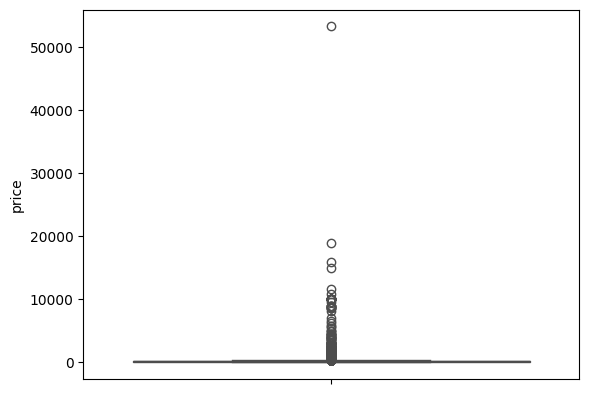

In [159]:
sns.boxplot(df.price, color='fuchsia')

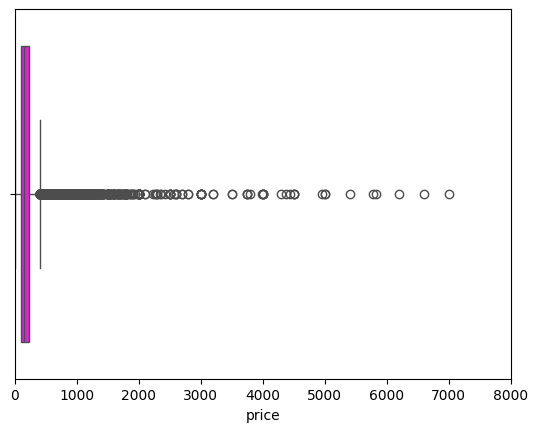

In [160]:
# Assuming df is your DataFrame and it has a column named 'price'
sns.boxplot(x=df['price'], color='fuchsia')
plt.xlim(0, 8000)  # Setting the y-axis limit from 0 to 10,000
plt.show()

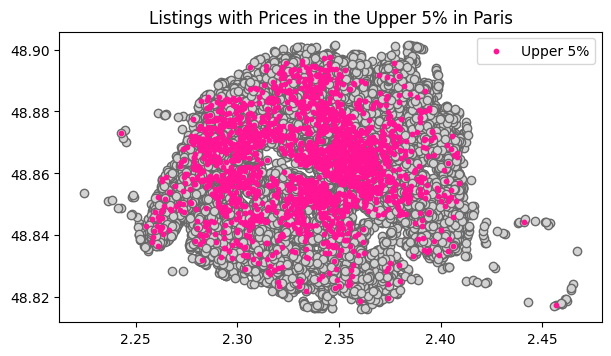

In [161]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'],df['latitude']))
gdf = gdf.set_crs('epsg:4326')

# Calculate the 95th percentile value for the price column
price_95th_percentile = gdf['price'].quantile(0.95)

# Filter the dataset to get the listings with prices above the 95th percentile value
high_price_listings = gdf[gdf['price'] > price_95th_percentile]

# Plot these listings on a map
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the base map of Paris (you can use the entire gdf to plot the boundaries)
gdf.plot(ax=ax, color='lightgrey', edgecolor='dimgrey')

# Plot the high price listings
high_price_listings.plot(ax=ax, color='deeppink', markersize=10, label='Upper 5%')

# Add titles and legend
plt.title('Listings with Prices in the Upper 5% in Paris')
plt.legend()
plt.show()

In [162]:
# Calculate the 95th percentile of prices
price_95th_percentile = df['price'].quantile(0.95)

# Filter out listings with prices above the 95th percentile
df = df[df['price'] <= price_95th_percentile]

# Verify the changes by displaying the new summary of the price column
print(df['price'].describe(percentiles=[0.25, 0.5, 0.75, 0.95]))

count    39584.000000
mean       163.104234
std         91.862663
min          8.000000
25%         97.000000
50%        138.000000
75%        200.000000
95%        359.000000
max        497.000000
Name: price, dtype: float64


<Axes: xlabel='price', ylabel='Count'>

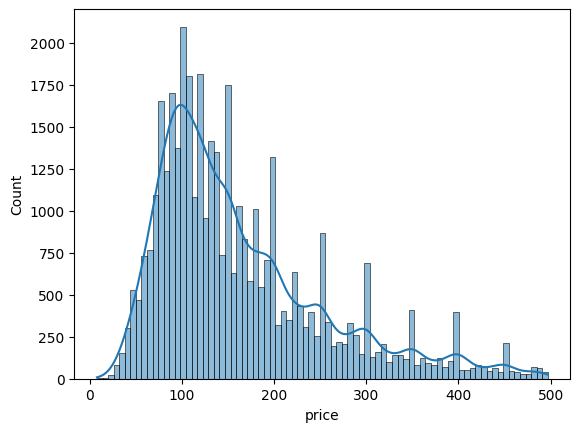

In [163]:
# Plot the distribution
sns.histplot(df['price'], kde=True)

In [164]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
df.describe()

id      latitude     longitude  accommodates      bedrooms  \
count  3.958400e+04  39584.000000  39584.000000  39584.000000  39584.000000   
mean   4.826787e+17     48.864269      2.344390      3.161631      1.191795   
std    4.417391e+17      0.017883      0.033103      1.590589      0.851621   
min    3.109000e+03     48.816080      2.224640      1.000000      0.000000   
25%    3.280059e+07     48.851604      2.324138      2.000000      1.000000   
50%    6.432230e+17     48.865527      2.347955      2.000000      1.000000   
75%    9.126661e+17     48.878520      2.368030      4.000000      1.000000   
max    1.110937e+18     48.901590      2.467120     16.000000     50.000000   

               beds         price  minimum_nights  number_of_reviews  \
count  39584.000000  39584.000000    39584.000000       39584.000000   
mean       1.687424    163.104234       10.579780          36.463015   
std        1.147526     91.862663       42.951109          69.465490   
min        0.000000      8.000000        1.000000           0.000000   
25%        1.000000     97.000000        2.000000           4.000000   
50%        1.000000    138.000000        3.000000          14.000000   
75%        2.000000    200.000000        4.000000          38.000000   
max       77.000000    497.000000     1123.000000        2905.000000   

       review_scores_rating  calculated_host_listings_count  \
count          39584.000000                    39584.000000   
mean               4.715311                       21.411707   
std                0.398688                       71.819848   
min                0.000000                        1.000000   
25%                4.600000                        1.000000   
50%                4.830000                        1.000000   
75%                5.000000                        5.000000   
max                5.000000                      676.000000   

       review_scores_location  Entire rental unit  \
count            39584.000000        39584.000000   
mean                 4.813624            0.825384   
std                  0.304461            0.379643   
min                  1.000000            0.000000   
25%                  4.750000            1.000000   
50%                  4.910000            1.000000   
75%                  5.000000            1.000000   
max                  5.000000            1.000000   

       Private room in rental unit  Entire condo         Other  \
count                 39584.000000  39584.000000  39584.000000   
mean                      0.054694      0.037717      0.082205   
std                       0.227384      0.190514      0.274680   
min                       0.000000      0.000000      0.000000   
25%                       0.000000      0.000000      0.000000   
50%                       0.000000      0.000000      0.000000   
75%                       0.000000      0.000000      0.000000   
max                       1.000000      1.000000      1.000000   

       Entire home/apt  Private room   Shared room    Hotel room  
count     39584.000000  39584.000000  39584.000000  39584.000000  
mean          0.894301      0.091325      0.004977      0.009398  
std           0.307456      0.288074      0.070371      0.096487  
min           0.000000      0.000000      0.000000      0.000000  
25%           1.000000      0.000000      0.000000      0.000000  
50%           1.000000      0.000000      0.000000      0.000000  
75%           1.000000      0.000000      0.000000      0.000000  
max           1.000000      1.000000      1.000000      1.000000

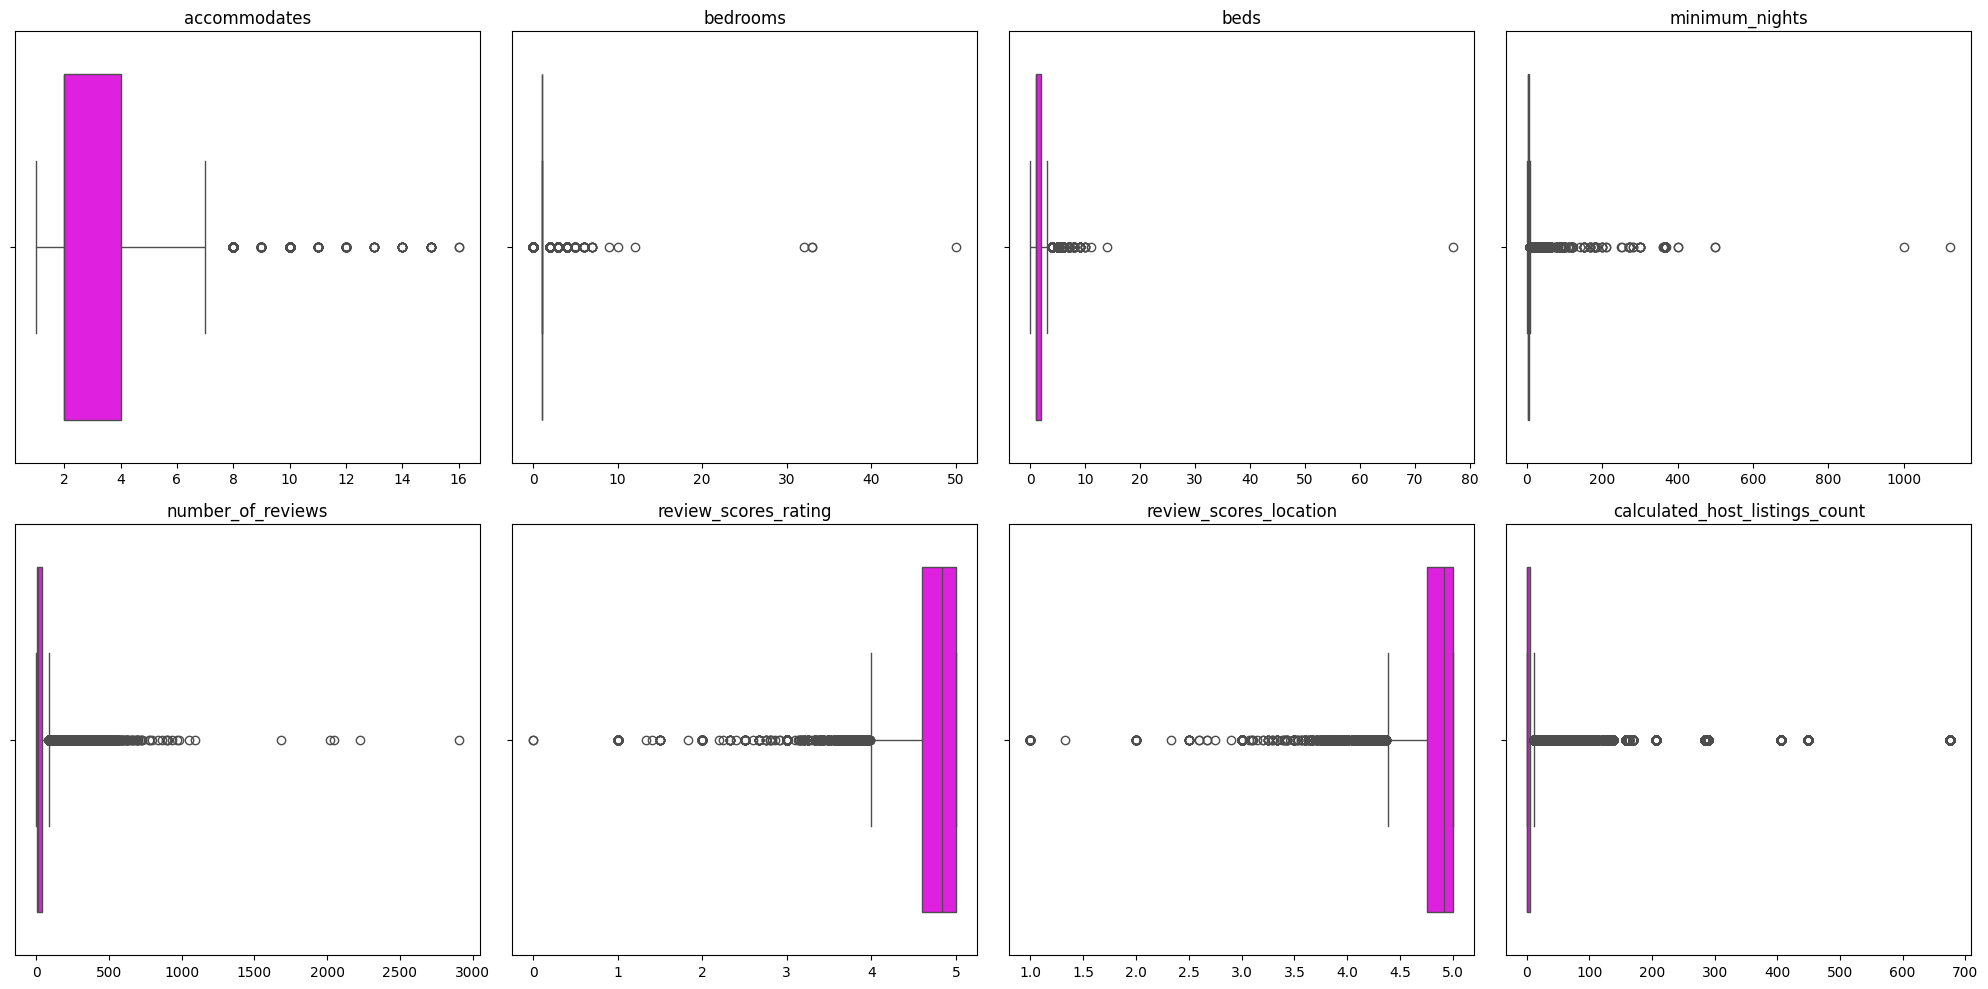

In [165]:
# Columns to include in the boxplots
columns_to_plot = ["accommodates", "bedrooms", "beds", "minimum_nights",
                   "number_of_reviews", "review_scores_rating", "review_scores_location", "calculated_host_listings_count"]

# Create subplots with multiple boxplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Loop through each column and create a boxplot for the first 4 variables
for i, column in enumerate(columns_to_plot[:4]):
    sns.boxplot(x=df[column], ax=axes[0, i], color='fuchsia')
    axes[0, i].set_title(f'{column}')
    axes[0, i].set_xlabel('')  # Remove x-axis label to save space

# Loop through each column and create a boxplot for the next 4 variables
for i, column in enumerate(columns_to_plot[4:]):
    sns.boxplot(x=df[column], ax=axes[1, i], color='fuchsia')
    axes[1, i].set_title(f'{column}')
    axes[1, i].set_xlabel('')  # Remove x-axis label to save space

plt.tight_layout()
plt.show()

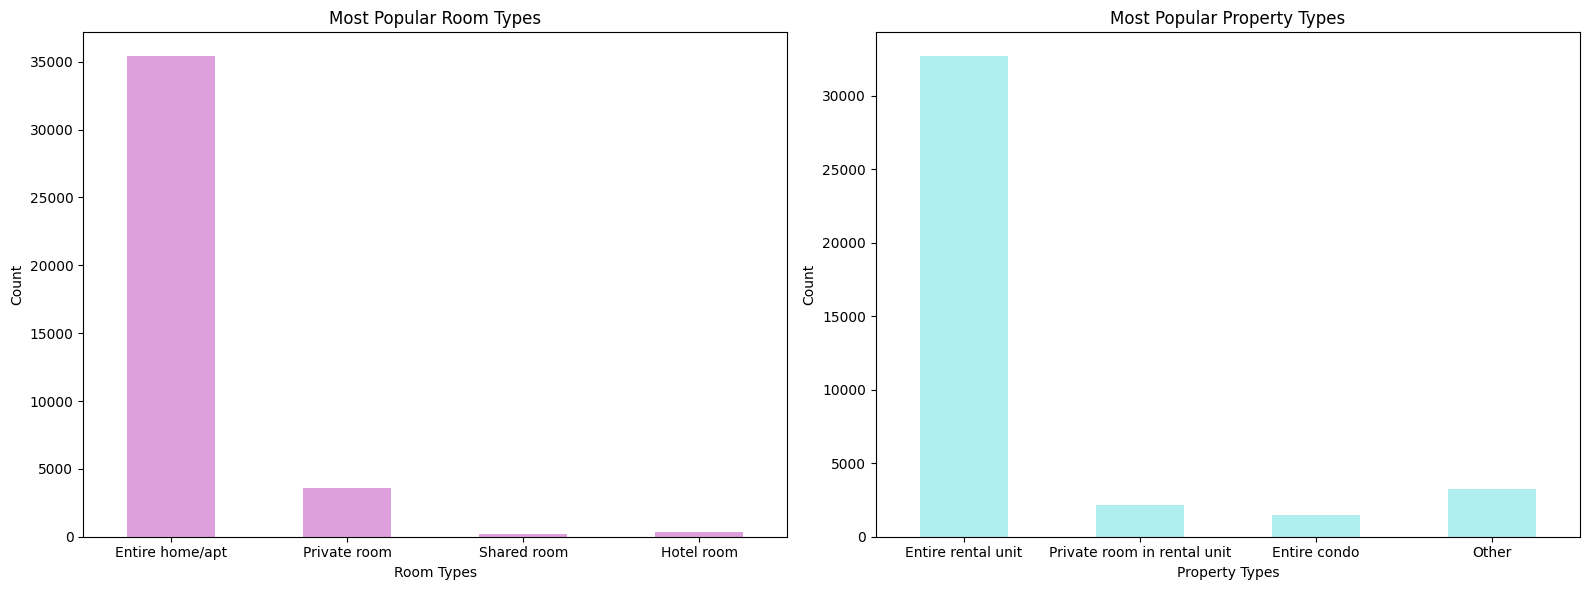

In [166]:
# Binary columns to visualize
room_type_columns = ["Entire home/apt", "Private room", "Shared room", "Hotel room"]
property_type_columns = ["Entire rental unit", "Private room in rental unit", "Entire condo", "Other"]

# Calculate the sum of each column
room_type_sums = df[room_type_columns].sum()
property_type_sums = df[property_type_columns].sum()

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Create a bar plot of the room type sums on the first subplot
room_type_sums.plot(kind='bar', ax=axes[0], rot=0, color='plum')
axes[0].set_title('Most Popular Room Types')
axes[0].set_xlabel('Room Types')
axes[0].set_ylabel('Count')

# Create a bar plot of the property type sums on the second subplot
property_type_sums.plot(kind='bar', ax=axes[1], rot=0, color='paleturquoise')
axes[1].set_title('Most Popular Property Types')
axes[1].set_xlabel('Property Types')
axes[1].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [167]:
# Renaming individual columns using the rename() method decipher between property type and room type
df.rename(columns={
    'Entire rental unit': 'pt Entire Rental Unit',
    'Private room in rental unit': 'pt Private Room in Rental Unit',
    'Entire condo': 'pt Entire Condo',
    'Other': 'pt Other',
    'Entire home/apt': 'rt Entire Home/Apt',
    'Private room': 'rt Private Room',
    'Shared room': 'rt Shared Room',
    'Hotel room': 'rt Hotel Room',
    'neighbourhood_cleansed': 'neighbourhood'
}, inplace=True)

In [168]:
df.head()

id  latitude  longitude   neighbourhood  accommodates  bedrooms  beds  \
0    3109  48.83191    2.31870    Observatoire             2       1.0   1.0   
1  165409  48.86652    2.36261          Temple             2       0.0   1.0   
2    5396  48.85247    2.35835  Hôtel-de-Ville             2       0.0   1.0   
3  166370  48.87623    2.36869        Entrepôt             4       1.0   1.0   
6    7397  48.85909    2.35315  Hôtel-de-Ville             4       2.0   2.0   

   price  minimum_nights  number_of_reviews  review_scores_rating  \
0  250.0               2                  4                  5.00   
1  140.0               3                106                  4.68   
2  107.0               1                393                  4.60   
3  200.0               2                 78                  4.56   
6  134.0              10                348                  4.73   

   calculated_host_listings_count  review_scores_location  \
0                               1                    5.00   
1                               1                    4.95   
2                               2                    4.96   
3                               1                    4.65   
6                               6                    4.93   

   pt Entire Rental Unit  pt Private Room in Rental Unit  pt Entire Condo  \
0                      1                               0                0   
1                      1                               0                0   
2                      1                               0                0   
3                      1                               0                0   
6                      1                               0                0   

   pt Other  rt Entire Home/Apt  rt Private Room  rt Shared Room  \
0         0                   1                0               0   
1         0                   1                0               0   
2         0                   1                0               0   
3         0                   1                0               0   
6         0                   1                0               0   

   rt Hotel Room  
0              0  
1              0  
2              0  
3              0  
6              0

/var/folders/ld/dtk9yjf946lgsbhl38x8n4f80000gp/T/ipykernel_2365/2326955902.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_correlations.values, y=price_correlations.index, palette='viridis')


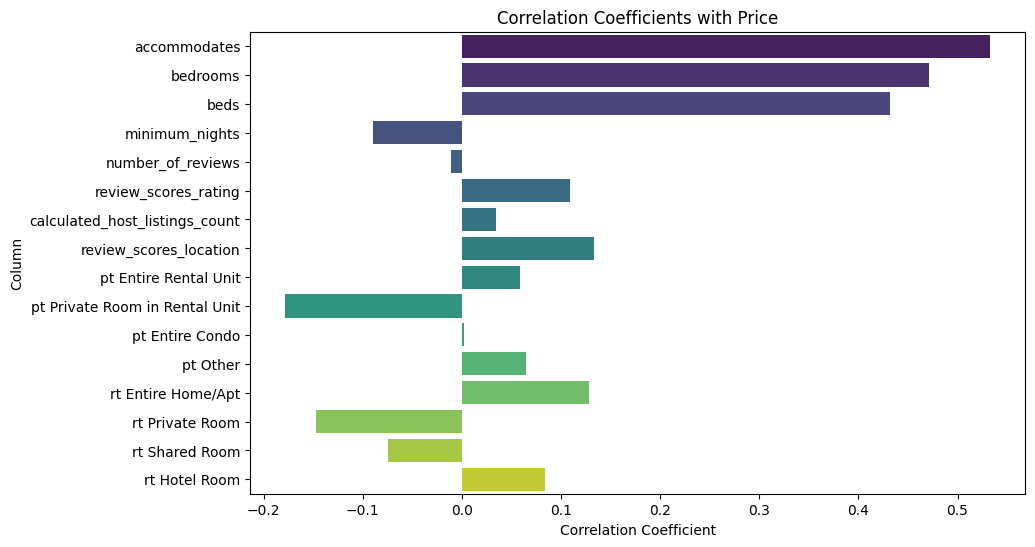

In [169]:
# List of columns to exclude from correlation calculation
exclude_columns = ['longitude', 'latitude', 'id', 'neighbourhood']

# Filter numerical columns excluding the specified ones
numerical_columns = [col for col in df.columns if col not in exclude_columns]

# Calculate correlation coefficients
correlation_matrix = df[numerical_columns].corr()

# Extract correlations with price
price_correlations = correlation_matrix['price'].drop('price')

# Plot correlation coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=price_correlations.values, y=price_correlations.index, palette='viridis')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Column')
plt.title('Correlation Coefficients with Price')
plt.show()

In [170]:
# Extract correlations with price
correlation_matrix['price'].drop('price')

accommodates                      0.532669
bedrooms                          0.470802
beds                              0.431421
minimum_nights                   -0.089320
number_of_reviews                -0.011321
review_scores_rating              0.108722
calculated_host_listings_count    0.034121
review_scores_location            0.133514
pt Entire Rental Unit             0.058867
pt Private Room in Rental Unit   -0.178119
pt Entire Condo                   0.002455
pt Other                          0.064386
rt Entire Home/Apt                0.128355
rt Private Room                  -0.147060
rt Shared Room                   -0.074297
rt Hotel Room                     0.084252
Name: price, dtype: float64

In [171]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'],df['latitude']))
gdf = gdf.set_crs('epsg:4326')

### Ordinary Linear Regression without any spatial aspect

In [172]:
df.head()

id  latitude  longitude   neighbourhood  accommodates  bedrooms  beds  \
0    3109  48.83191    2.31870    Observatoire             2       1.0   1.0   
1  165409  48.86652    2.36261          Temple             2       0.0   1.0   
2    5396  48.85247    2.35835  Hôtel-de-Ville             2       0.0   1.0   
3  166370  48.87623    2.36869        Entrepôt             4       1.0   1.0   
6    7397  48.85909    2.35315  Hôtel-de-Ville             4       2.0   2.0   

   price  minimum_nights  number_of_reviews  review_scores_rating  \
0  250.0               2                  4                  5.00   
1  140.0               3                106                  4.68   
2  107.0               1                393                  4.60   
3  200.0               2                 78                  4.56   
6  134.0              10                348                  4.73   

   calculated_host_listings_count  review_scores_location  \
0                               1                    5.00   
1                               1                    4.95   
2                               2                    4.96   
3                               1                    4.65   
6                               6                    4.93   

   pt Entire Rental Unit  pt Private Room in Rental Unit  pt Entire Condo  \
0                      1                               0                0   
1                      1                               0                0   
2                      1                               0                0   
3                      1                               0                0   
6                      1                               0                0   

   pt Other  rt Entire Home/Apt  rt Private Room  rt Shared Room  \
0         0                   1                0               0   
1         0                   1                0               0   
2         0                   1                0               0   
3         0                   1                0               0   
6         0                   1                0               0   

   rt Hotel Room  
0              0  
1              0  
2              0  
3              0  
6              0

In [173]:
nonspatial_variables = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count',
            'review_scores_location', 'pt Entire Rental Unit', 'pt Private Room in Rental Unit', 'pt Entire Condo',	'pt Other', 'rt Entire Home/Apt',
            'rt Private Room', 'rt Shared Room', 'rt Hotel Room']

#### Creating a Baseline Regression Model

In [174]:
def perform_cross_validated_regression(df, target_var, feature_vars, n_splits=5):
    # Define namedtuples for storing the metrics
    Metrics = namedtuple('Metrics', ['mean', 'std_dev'])
    AllMetrics = namedtuple('AllMetrics', ['rmse', 'mae', 'r2_adj'])
    
    # Split the data into features and target variable
    X = df[feature_vars]
    y = df[target_var]
    
    # Initialize the KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initialize lists to store the metrics for each fold
    rmse_list = []
    mae_list = []
    r2_adj_list = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Fit the OLS model on the training data
        model = sm.OLS(endog=y_train, exog=sm.add_constant(X_train))
        results = model.fit()
        
        # Predict on the validation data
        X_val_const = sm.add_constant(X_val)
        predicted_val = results.predict(X_val_const)
        
        # Calculate the metrics on the validation data
        r_squared = r2_score(y_val, predicted_val)
        rmse = np.sqrt(mean_squared_error(y_val, predicted_val))
        mae = mean_absolute_error(y_val, predicted_val)
        # Calculate adjusted R-squared 
        n = X_val.shape[0]  # Number of observations in validation set
        p = X_val.shape[1]  # Number of predictors in the model
        r_squared_adj = 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))
        
        # Append the metrics to the lists
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_adj_list.append(r_squared_adj)
    
    # Calculate the mean and standard deviation of the metrics
    rmse_metrics = Metrics(mean=np.mean(rmse_list), std_dev=np.std(rmse_list))
    mae_metrics = Metrics(mean=np.mean(mae_list), std_dev=np.std(mae_list))
    r2_adj_metrics = Metrics(mean=np.mean(r2_adj_list), std_dev=np.std(r2_adj_list))
    
    # Store all metrics in a namedtuple
    all_metrics = AllMetrics(
        rmse=rmse_metrics,
        mae=mae_metrics,
        r2_adj=r2_adj_metrics
    )
    
    # Return the performance metrics
    return all_metrics, results

In [175]:
results1, model1 = perform_cross_validated_regression(gdf, target_var='price', feature_vars=nonspatial_variables)

In [176]:
non_spatial_metrics = pd.DataFrame(
    [[results1.rmse.mean], [results1.mae.mean], [results1.r2_adj.mean]],
    index=["RMSE", "MAE", "Adjusted R2"],
    columns=["Non Spatial"],
)

In [177]:
non_spatial_metrics

Non Spatial
RMSE           73.327495
MAE            53.764690
Adjusted R2     0.361417

### Geographic Analysis

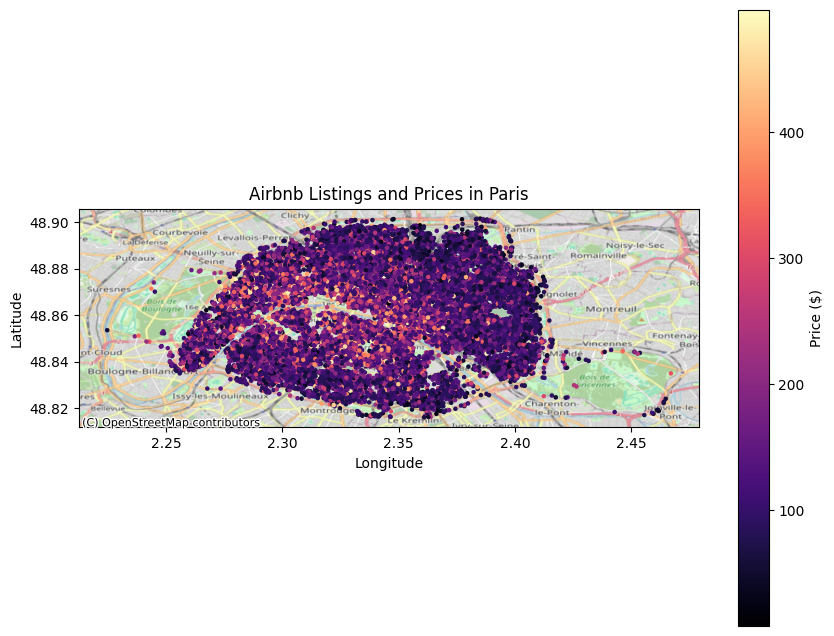

In [178]:

# Plot the basemap of Paris
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Airbnb listings
gdf.plot(ax=ax, column='price', legend=True, legend_kwds={'label': "Price ($)"}, markersize=5, cmap='magma')

# Add basemap using OpenStreetMap
cx.add_basemap(ax=ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

# Set title and labels
plt.title('Airbnb Listings and Prices in Paris')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show plot
plt.show()

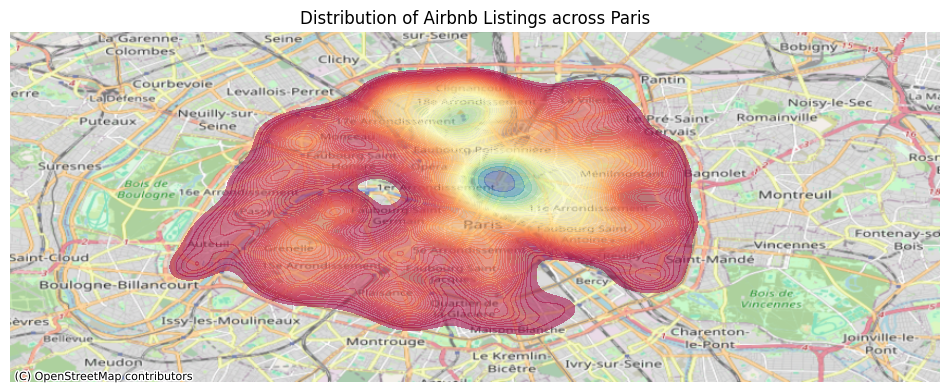

In [179]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))

sns.kdeplot(
    x="longitude",
    y="latitude",
    data=gdf,
    n_levels=50,
    fill=True,
    alpha=0.55,
    cmap="Spectral",
    ax=ax
)

# Add basemap
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title('Distribution of Airbnb Listings across Paris')
plt.show()

## Adding space 

In [180]:
filepath2 = 'neighbourhoods.geojson'
neis = gpd.read_file(filepath2)

print(type(neis))
print(neis.shape)
neis.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(20, 3)


neighbourhood neighbourhood_group  \
0  Batignolles-Monceau                None   
1       Palais-Bourbon                None   
2      Buttes-Chaumont                None   
3                Opéra                None   
4             Entrepôt                None   

                                            geometry  
0  MULTIPOLYGON (((2.29517 48.87396, 2.29504 48.8...  
1  MULTIPOLYGON (((2.32090 48.86306, 2.32094 48.8...  
2  MULTIPOLYGON (((2.38943 48.90122, 2.39014 48.9...  
3  MULTIPOLYGON (((2.33978 48.88203, 2.33982 48.8...  
4  MULTIPOLYGON (((2.36469 48.88437, 2.36485 48.8...

/var/folders/ld/dtk9yjf946lgsbhl38x8n4f80000gp/T/ipykernel_2365/2700768381.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', num_neighborhoods)


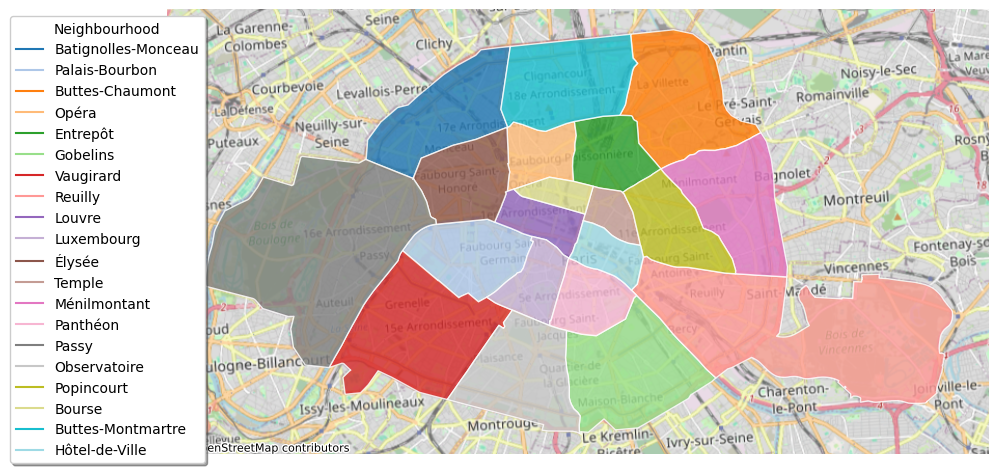

In [181]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(10, 10))

# Extract unique neighborhoods and count
neighborhoods = neis['neighbourhood'].unique()
num_neighborhoods = len(neighborhoods)

cmap = plt.cm.get_cmap('tab20', num_neighborhoods)

for idx, neighborhood in enumerate(neighborhoods):
    neis[neis['neighbourhood'] == neighborhood].to_crs(epsg="25830").plot(
        ax=ax, color=cmap(idx), label=neighborhood, edgecolor='white', alpha=0.8
    )

# Add basemap
cx.add_basemap(ax=ax, crs=neis.to_crs(epsg="25830").crs, source=cx.providers.OpenStreetMap.Mapnik)

handles, labels = [], []
for idx, neighborhood in enumerate(neighborhoods):
    handles.append(plt.Line2D([0, 1], [0, 1], color=cmap(idx), label=neighborhood))
    labels.append(neighborhood)

# Display legend next to the plot on the left
ax.legend(handles, labels, title='Neighbourhood', loc='upper left', bbox_to_anchor=(-0.2, 1), fancybox=True, shadow=True)

# Turn off axis
ax.set_axis_off()

# Show plot
plt.tight_layout()
plt.show()


/var/folders/ld/dtk9yjf946lgsbhl38x8n4f80000gp/T/ipykernel_2365/4189657355.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=neighborhood_prices.values, y=neighborhood_prices.index, palette="viridis")


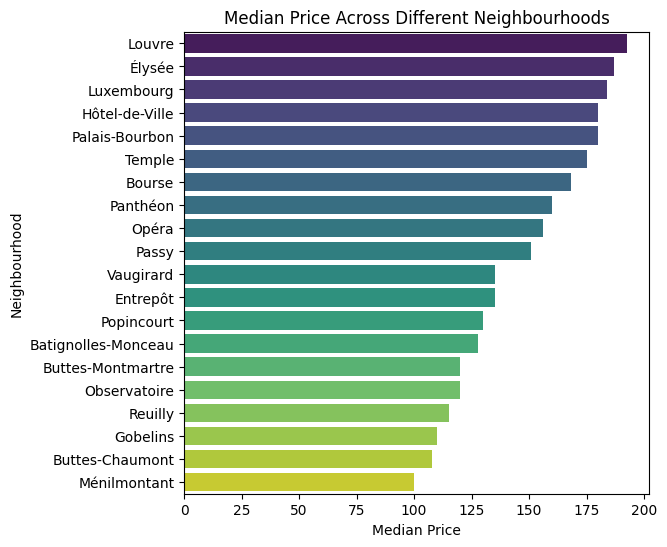

In [182]:
# Calculate the median price for each neighborhood
neighborhood_prices = df.groupby("neighbourhood")["price"].median().sort_values(ascending=False)

# Create a bar plot to visualize the median price for each neighborhood
plt.figure(figsize=(6, 6))
sns.barplot(x=neighborhood_prices.values, y=neighborhood_prices.index, palette="viridis")
plt.xlabel("Median Price")
plt.ylabel("Neighbourhood")
plt.title("Median Price Across Different Neighbourhoods")
plt.show()

In [183]:
# Encode the neighbourhood_cleansed column
gdf = pd.get_dummies(gdf, columns=['neighbourhood'], drop_first=False)

In [184]:
gdf.head(2)

id  latitude  longitude  accommodates  bedrooms  beds  price  \
0    3109  48.83191    2.31870             2       1.0   1.0  250.0   
1  165409  48.86652    2.36261             2       0.0   1.0  140.0   

   minimum_nights  number_of_reviews  review_scores_rating  \
0               2                  4                  5.00   
1               3                106                  4.68   

   calculated_host_listings_count  review_scores_location  \
0                               1                    5.00   
1                               1                    4.95   

   pt Entire Rental Unit  pt Private Room in Rental Unit  pt Entire Condo  \
0                      1                               0                0   
1                      1                               0                0   

   pt Other  rt Entire Home/Apt  rt Private Room  rt Shared Room  \
0         0                   1                0               0   
1         0                   1                0               0   

   rt Hotel Room                  geometry  neighbourhood_Batignolles-Monceau  \
0              0  POINT (2.31870 48.83191)                                  0   
1              0  POINT (2.36261 48.86652)                                  0   

   neighbourhood_Bourse  neighbourhood_Buttes-Chaumont  \
0                     0                              0   
1                     0                              0   

   neighbourhood_Buttes-Montmartre  neighbourhood_Entrepôt  \
0                                0                       0   
1                                0                       0   

   neighbourhood_Gobelins  neighbourhood_Hôtel-de-Ville  neighbourhood_Louvre  \
0                       0                             0                     0   
1                       0                             0                     0   

   neighbourhood_Luxembourg  neighbourhood_Ménilmontant  \
0                         0                           0   
1                         0                           0   

   neighbourhood_Observatoire  neighbourhood_Opéra  \
0                           1                    0   
1                           0                    0   

   neighbourhood_Palais-Bourbon  neighbourhood_Panthéon  neighbourhood_Passy  \
0                             0                       0                    0   
1                             0                       0                    0   

   neighbourhood_Popincourt  neighbourhood_Reuilly  neighbourhood_Temple  \
0                         0                      0                     0   
1                         0                      0                     1   

   neighbourhood_Vaugirard  neighbourhood_Élysée  
0                        0                     0  
1                        0                     0

In [185]:
gdf_withnbhoods = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count',
            'review_scores_location', 'pt Entire Rental Unit', 'pt Private Room in Rental Unit', 'pt Entire Condo',	'pt Other', 'rt Entire Home/Apt',
            'rt Private Room', 'rt Shared Room', 'rt Hotel Room', 'neighbourhood_Batignolles-Monceau', 'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Montmartre',
            'neighbourhood_Entrepôt', 'neighbourhood_Gobelins', 'neighbourhood_Hôtel-de-Ville', 'neighbourhood_Louvre', 'neighbourhood_Luxembourg',
            'neighbourhood_Ménilmontant', 'neighbourhood_Observatoire', 'neighbourhood_Opéra', 'neighbourhood_Palais-Bourbon', 'neighbourhood_Panthéon',
            'neighbourhood_Passy', 'neighbourhood_Popincourt', 'neighbourhood_Reuilly', 'neighbourhood_Temple', 'neighbourhood_Vaugirard', 'neighbourhood_Élysée']

In [186]:
results2, model2 = perform_cross_validated_regression(gdf, target_var='price', feature_vars=gdf_withnbhoods)

In [187]:
metrics2 = pd.DataFrame(
    [[results1.rmse.mean, results2.rmse.mean],
     [results1.mae.mean, results2.mae.mean],
     [results1.r2_adj.mean, results2.r2_adj.mean],],
    index=["RMSE", "MAE", "R2 Adjusted"],
    columns=["Non Spatial", "With Neighbourhoods"]
)


In [188]:
metrics2

Non Spatial  With Neighbourhoods
RMSE           73.327495            69.359654
MAE            53.764690            50.056972
R2 Adjusted     0.361417             0.427211

## Spatial Feature Engineering

### Amenity POIs

- bar
- restaurant
- arts_centre
- café
- nightclub


In [189]:
pois_bar = ox.features_from_address(
    "Paris, France", dist = 3500, tags={"amenity": "bar"}
)
pois_restaurant = ox.features_from_address(
    "Paris, France", dist = 3500, tags={"amenity": "restaurant"}
)
pois_arts_centre = ox.features_from_address(
    "Paris, France", dist = 3500, tags={"amenity": "arts_centre"}
)
pois_cafe = ox.features_from_address(
    "Paris, France", dist = 3500, tags={"amenity": "cafe"}
)
pois_nightclub = ox.features_from_address(
    "Paris, France", dist = 3500, tags={"amenity": "nightclub"}
)

In [190]:
pois_restaurant.head()

air_conditioning        alt_name     amenity  \
element_type osmid                                                    
node         158603712              yes  Le Moulin Vert  restaurant   
             175539450              yes             NaN  restaurant   
             247439841              NaN             NaN  restaurant   
             247455916              NaN             NaN  restaurant   
             247455920              NaN             NaN  restaurant   

                              cuisine  happy_hours indoor_seating  \
element_type osmid                                                  
node         158603712          pizza  15:00-20:00            yes   
             175539450         french          NaN            yes   
             247439841  italian;pizza          NaN            yes   
             247455916            NaN          NaN            NaN   
             247455920            NaN          NaN            NaN   

                                        name outdoor_seating  \
element_type osmid                                             
node         158603712  The Village Terrazza             yes   
             175539450             Le Severo              no   
             247439841                   Uno             yes   
             247455916      La Crypte Polska             NaN   
             247455920       Mystery Cuisine             NaN   

                       payment:credit_cards payment:debit_cards  \
element_type osmid                                                
node         158603712                  yes                 yes   
             175539450                  yes                 yes   
             247439841                  NaN                 NaN   
             247455916                  NaN                 NaN   
             247455920                  NaN                 NaN   

                                    phone  smoking wheelchair  \
element_type osmid                                              
node         158603712  +33 1 45 39 31 31  outside        yes   
             175539450                NaN       no        yes   
             247439841                NaN  outside    limited   
             247455916                NaN      NaN        NaN   
             247455920                NaN      NaN        NaN   

                                        geometry addr:housenumber  \
element_type osmid                                                  
node         158603712  POINT (2.32287 48.82984)              NaN   
             175539450  POINT (2.32453 48.83199)                8   
             247439841  POINT (2.34350 48.86185)               37   
             247455916  POINT (2.32555 48.86729)              NaN   
             247455920  POINT (2.33724 48.86590)              NaN   

                       addr:postcode      addr:street  \
element_type osmid                                      
node         158603712           NaN              NaN   
             175539450         75014  Rue des Plantes   
             247439841         75001       Rue Berger   
             247455916           NaN              NaN   
             247455920           NaN              NaN   

                                        opening_hours addr:city contact:city  \
element_type osmid                                                             
node         158603712                            NaN       NaN          NaN   
             175539450  Mo-Fr 12:00-14:00,19:30-21:30       NaN          NaN   
             247439841              Mo-Su 12:00-00:00     Paris        Paris   
             247455916                            NaN       NaN          NaN   
             247455920                            NaN       NaN        Paris   

                       contact:housenumber      contact:phone  \
element_type osmid                                              
node         158603712                 NaN                NaN   
             175539450    

<Axes: >

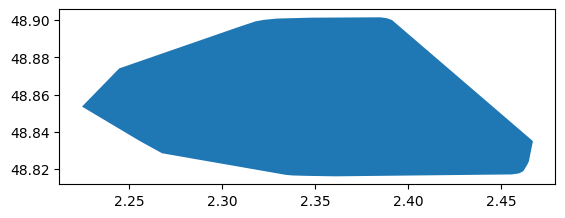

In [191]:
polygon = gdf.unary_union.convex_hull
gpd.GeoSeries([polygon]).plot()

In [192]:
pois = ox.geometries_from_polygon(polygon, tags={"amenity": ["bar", "restaurant", "cafe", "arts_centre", "nightclub"]}).reset_index()[
    [
        "element_type",
        "osmid",
        "amenity",
        "addr:street",
        "name",
        "geometry",
    ]
]

/var/folders/ld/dtk9yjf946lgsbhl38x8n4f80000gp/T/ipykernel_2365/4136528127.py:1: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags={"amenity": ["bar", "restaurant", "cafe", "arts_centre", "nightclub"]}).reset_index()[


In [193]:
pois.head()

element_type      osmid     amenity      addr:street                  name  \
0         node  158603712  restaurant              NaN  The Village Terrazza   
1         node  175539450  restaurant  Rue des Plantes             Le Severo   
2         node  247439149         bar              NaN         Bar Hemingway   
3         node  247439841  restaurant       Rue Berger                   Uno   
4         node  247455913         bar              NaN            Juvénile's   

                   geometry  
0  POINT (2.32287 48.82984)  
1  POINT (2.32453 48.83199)  
2  POINT (2.32751 48.86879)  
3  POINT (2.34350 48.86185)  
4  POINT (2.33708 48.86632)

The resulting `pois` geodataframe may have a composite row index. In addition, some POIs may be of a strange element_type. I will use the following code to eliminate these issues and clean the data

In [194]:
# Clean the POI data
pois.reset_index(inplace=True) # reset the index of the data frame
pois = pois[pois.element_type=="node"] # eliminate all POIs that are not of the type "node"
pois.head() # check the results

index element_type      osmid     amenity      addr:street  \
0      0         node  158603712  restaurant              NaN   
1      1         node  175539450  restaurant  Rue des Plantes   
2      2         node  247439149         bar              NaN   
3      3         node  247439841  restaurant       Rue Berger   
4      4         node  247455913         bar              NaN   

                   name                  geometry  
0  The Village Terrazza  POINT (2.32287 48.82984)  
1             Le Severo  POINT (2.32453 48.83199)  
2         Bar Hemingway  POINT (2.32751 48.86879)  
3                   Uno  POINT (2.34350 48.86185)  
4            Juvénile's  POINT (2.33708 48.86632)

In [195]:
poi_counts = pois.groupby("amenity").amenity.count()
poi_counts

amenity
arts_centre      98
bar            1848
cafe           2169
nightclub        61
restaurant     8690
Name: amenity, dtype: int64

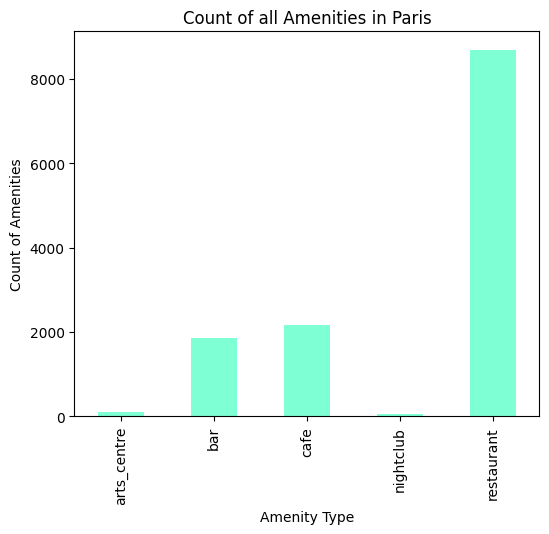

In [196]:
poi_counts.plot(kind='bar', figsize=(6, 5), color='aquamarine')

# Setzen Sie den Titel und die Beschriftungen der Achsen
plt.title('Count of all Amenities in Paris')
plt.xlabel('Amenity Type')
plt.ylabel('Count of Amenities')

# Zeigen Sie den Plot an
plt.show()

In [197]:
gdf.head()

id  latitude  longitude  accommodates  bedrooms  beds  price  \
0    3109  48.83191    2.31870             2       1.0   1.0  250.0   
1  165409  48.86652    2.36261             2       0.0   1.0  140.0   
2    5396  48.85247    2.35835             2       0.0   1.0  107.0   
3  166370  48.87623    2.36869             4       1.0   1.0  200.0   
6    7397  48.85909    2.35315             4       2.0   2.0  134.0   

   minimum_nights  number_of_reviews  review_scores_rating  \
0               2                  4                  5.00   
1               3                106                  4.68   
2               1                393                  4.60   
3               2                 78                  4.56   
6              10                348                  4.73   

   calculated_host_listings_count  review_scores_location  \
0                               1                    5.00   
1                               1                    4.95   
2                               2                    4.96   
3                               1                    4.65   
6                               6                    4.93   

   pt Entire Rental Unit  pt Private Room in Rental Unit  pt Entire Condo  \
0                      1                               0                0   
1                      1                               0                0   
2                      1                               0                0   
3                      1                               0                0   
6                      1                               0                0   

   pt Other  rt Entire Home/Apt  rt Private Room  rt Shared Room  \
0         0                   1                0               0   
1         0                   1                0               0   
2         0                   1                0               0   
3         0                   1                0               0   
6         0                   1                0               0   

   rt Hotel Room                  geometry  neighbourhood_Batignolles-Monceau  \
0              0  POINT (2.31870 48.83191)                                  0   
1              0  POINT (2.36261 48.86652)                                  0   
2              0  POINT (2.35835 48.85247)                                  0   
3              0  POINT (2.36869 48.87623)                                  0   
6              0  POINT (2.35315 48.85909)                                  0   

   neighbourhood_Bourse  neighbourhood_Buttes-Chaumont  \
0                     0                              0   
1                     0                              0   
2                     0                              0   
3                     0                              0   
6                     0                              0   

   neighbourhood_Buttes-Montmartre  neighbourhood_Entrepôt  \
0                                0                       0   
1                                0                       0   
2                                0                       0   
3                                0                       1   
6                                0                       0   

   neighbourhood_Gobelins  neighbourhood_Hôtel-de-Ville  neighbourhood_Louvre  \
0                       0                             0                     0   
1                       0                             0                     0   
2                       0                             1                     0   
3                       0                             0                     0   
6                       0                             1                     0   

   neighbourhood_Luxembourg  neighbourhood_Ménilmontant  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         0         

##### Using KD-Trees for Nearest Neighbor Search:

In [198]:
# Initialize columns for distances to each type of POI
gdf['dist_to_restaurant'] = np.nan
gdf['dist_to_arts_centre'] = np.nan
gdf['dist_to_cafe'] = np.nan
gdf['dist_to_bar'] = np.nan
gdf['dist_to_nightclub'] = np.nan

In [199]:
# Extract coordinates
airbnb_coords = np.array(list(gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
poi_coords = {poi_type: np.array(list(pois[pois['amenity'] == poi_type].geometry.apply(lambda geom: (geom.x, geom.y)))) for poi_type in ['restaurant', 'arts_centre', 'cafe', 'bar', 'nightclub']}

In [200]:
kdtrees = {poi_type: cKDTree(coords) for poi_type, coords in poi_coords.items()}

In [201]:
distances = {poi_type: kdtree.query(airbnb_coords)[0] for poi_type, kdtree in kdtrees.items()}

# Add distances to the GeoDataFrame
for poi_type, dist in distances.items():
    gdf[f'dist_to_{poi_type}'] = dist

In [202]:
gdf.head()

id  latitude  longitude  accommodates  bedrooms  beds  price  \
0    3109  48.83191    2.31870             2       1.0   1.0  250.0   
1  165409  48.86652    2.36261             2       0.0   1.0  140.0   
2    5396  48.85247    2.35835             2       0.0   1.0  107.0   
3  166370  48.87623    2.36869             4       1.0   1.0  200.0   
6    7397  48.85909    2.35315             4       2.0   2.0  134.0   

   minimum_nights  number_of_reviews  review_scores_rating  \
0               2                  4                  5.00   
1               3                106                  4.68   
2               1                393                  4.60   
3               2                 78                  4.56   
6              10                348                  4.73   

   calculated_host_listings_count  review_scores_location  \
0                               1                    5.00   
1                               1                    4.95   
2                               2                    4.96   
3                               1                    4.65   
6                               6                    4.93   

   pt Entire Rental Unit  pt Private Room in Rental Unit  pt Entire Condo  \
0                      1                               0                0   
1                      1                               0                0   
2                      1                               0                0   
3                      1                               0                0   
6                      1                               0                0   

   pt Other  rt Entire Home/Apt  rt Private Room  rt Shared Room  \
0         0                   1                0               0   
1         0                   1                0               0   
2         0                   1                0               0   
3         0                   1                0               0   
6         0                   1                0               0   

   rt Hotel Room                  geometry  neighbourhood_Batignolles-Monceau  \
0              0  POINT (2.31870 48.83191)                                  0   
1              0  POINT (2.36261 48.86652)                                  0   
2              0  POINT (2.35835 48.85247)                                  0   
3              0  POINT (2.36869 48.87623)                                  0   
6              0  POINT (2.35315 48.85909)                                  0   

   neighbourhood_Bourse  neighbourhood_Buttes-Chaumont  \
0                     0                              0   
1                     0                              0   
2                     0                              0   
3                     0                              0   
6                     0                              0   

   neighbourhood_Buttes-Montmartre  neighbourhood_Entrepôt  \
0                                0                       0   
1                                0                       0   
2                                0                       0   
3                                0                       1   
6                                0                       0   

   neighbourhood_Gobelins  neighbourhood_Hôtel-de-Ville  neighbourhood_Louvre  \
0                       0                             0                     0   
1                       0                             0                     0   
2                       0                             1                     0   
3                       0                             0                     0   
6                       0                             1                     0   

   neighbourhood_Luxembourg  neighbourhood_Ménilmontant  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         0         

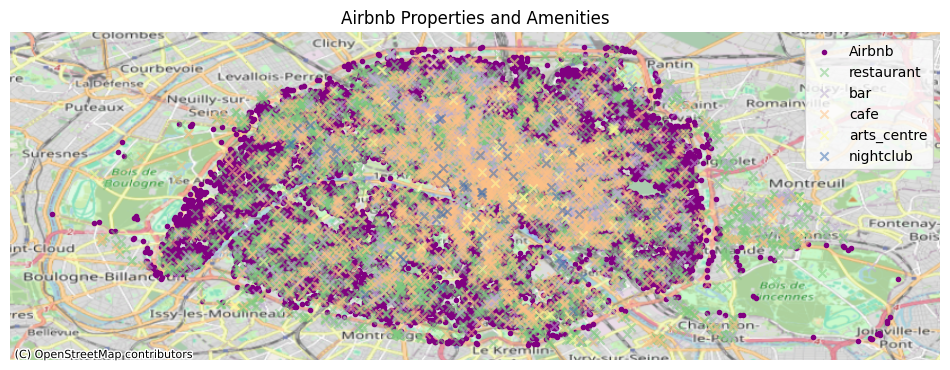

In [203]:

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))

# Plot Airbnb properties in purple
gdf.plot(ax=ax, marker=".", color="purple", label="Airbnb")

# Define a color pattern
colors = plt.get_cmap('Accent')

for i, amenity in enumerate(pois['amenity'].unique()):
    pois[pois['amenity'] == amenity].plot(ax=ax, color=colors(i), alpha=0.5, marker="x", label=amenity)

cx.add_basemap(
    ax,
    crs=gdf.crs.to_string(),
    source=cx.providers.OpenStreetMap.Mapnik,
)

# Remove axes
ax.set_axis_off()

# Add a legend
ax.legend()

# Add a title
plt.title('Airbnb Properties and Amenities')

# Display
plt.show()

In [204]:
gdf_with_dist_pois = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count',
            'review_scores_location', 'pt Entire Rental Unit', 'pt Private Room in Rental Unit', 'pt Entire Condo', 'pt Other', 'rt Entire Home/Apt',
            'rt Private Room', 'rt Shared Room', 'rt Hotel Room', 'neighbourhood_Batignolles-Monceau', 'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Montmartre',
            'neighbourhood_Entrepôt', 'neighbourhood_Gobelins', 'neighbourhood_Hôtel-de-Ville', 'neighbourhood_Louvre', 'neighbourhood_Luxembourg',
            'neighbourhood_Ménilmontant', 'neighbourhood_Observatoire', 'neighbourhood_Opéra', 'neighbourhood_Palais-Bourbon', 'neighbourhood_Panthéon',
            'neighbourhood_Passy', 'neighbourhood_Popincourt', 'neighbourhood_Reuilly', 'neighbourhood_Temple', 'neighbourhood_Vaugirard', 'neighbourhood_Élysée', 'dist_to_restaurant', 'dist_to_arts_centre', 'dist_to_cafe', 'dist_to_bar', 'dist_to_nightclub']

In [205]:
restaurant_dist = gdf_withnbhoods + ["dist_to_restaurant"]
bar_dist = gdf_withnbhoods + ["dist_to_bar"]
cafe_dist = gdf_withnbhoods + ["dist_to_cafe"]
art_dist = gdf_withnbhoods + ["dist_to_arts_centre"]
nightclub_dist = gdf_withnbhoods + ["dist_to_nightclub"]

In [206]:
restaurant_dist = gdf_withnbhoods + ["dist_to_restaurant"]
bar_dist = gdf_withnbhoods + ["dist_to_bar"]
cafe_dist = gdf_withnbhoods + ["dist_to_cafe"]
art_dist = gdf_withnbhoods + ["dist_to_arts_centre"]
nightclub_dist = gdf_withnbhoods + ["dist_to_nightclub"]

# Function to scale the features
def scale_features(gdf, gdf_with_dist_pois):
    scaler = StandardScaler()
    gdf[gdf_with_dist_pois] = scaler.fit_transform(gdf[gdf_with_dist_pois])#    return gdf

# Scale the features
gdf_scaled = scale_features(gdf, restaurant_dist)
gdf_scaled = scale_features(gdf, bar_dist)
gdf_scaled = scale_features(gdf, cafe_dist)
gdf_scaled = scale_features(gdf, art_dist)
gdf_scaled = scale_features(gdf, nightclub_dist)

In [207]:
results3, model3 = perform_cross_validated_regression(gdf, target_var='price', feature_vars=gdf_with_dist_pois)

In [208]:
metrics3 = pd.DataFrame(
    [[results1.rmse.mean, results2.rmse.mean, results3.rmse.mean],
     [results1.mae.mean, results2.mae.mean, results3.mae.mean],
     [results1.r2_adj.mean, results2.r2_adj.mean, results3.r2_adj.mean]],
    index=["RMSE", "MAE", "R2 Adjusted"],
    columns=["Non Spatial", "With Neighbourhoods", "With Distances to Amenities"]
)

In [209]:
metrics3

Non Spatial  With Neighbourhoods  With Distances to Amenities
RMSE           73.327495            69.359654                    69.010314
MAE            53.764690            50.056972                    49.722574
R2 Adjusted     0.361417             0.427211                     0.432601

##### Using Kernel Density Estimation (KDE) for Density Estimation of the POIs

In [210]:
def create_coordinate_array(geometries): 
    x_values = []
    y_values = []

    for multipoint in geometries:
        points = list(multipoint.geoms) if hasattr(multipoint, "geoms") else [multipoint]
        
        # For each Point extract x and y values
        for point in points:
            x_values.append(point.x)
            y_values.append(point.y)

    x_values = np.array(x_values)
    y_values = np.array(y_values)

    xy = np.vstack([x_values,y_values])

    return xy

In [211]:
coords_airbnbs = create_coordinate_array(gdf.geometry)
kde_func = gaussian_kde(coords_airbnbs)
kde_airbnbs = kde_func(coords_airbnbs)

In [212]:
# Function to create a coordinate array from geometries
def create_coordinate_array(geometry):
    return np.vstack([geometry.x, geometry.y])

# Define the coordinates for Airbnb listings
coords_airbnbs = create_coordinate_array(gdf.geometry)

# Density of the Restaurants
coords_restaurants = create_coordinate_array(pois[pois['amenity'] == 'restaurant'].geometry)
kde_func_restaurants = gaussian_kde(coords_restaurants)
kde_restaurants = kde_func_restaurants(coords_airbnbs)

# Density of the Bars
coords_bars = create_coordinate_array(pois[pois['amenity'] == 'bar'].geometry)
kde_func_bars = gaussian_kde(coords_bars)
kde_bars = kde_func_bars(coords_airbnbs)

# Density of the Art Centers
coords_cafe = create_coordinate_array(pois[pois['amenity'] == 'cafe'].geometry)
kde_func_cafe = gaussian_kde(coords_cafe)
kde_cafe = kde_func_cafe(coords_airbnbs)

# Density of the Art Centers
coords_art = create_coordinate_array(pois[pois['amenity'] == 'arts_centre'].geometry)
kde_func_art = gaussian_kde(coords_art)
kde_art = kde_func_art(coords_airbnbs)

# Density of the Nightclubs
coords_nightclub = create_coordinate_array(pois[pois['amenity'] == 'nightclub'].geometry)
kde_func_nightclub = gaussian_kde(coords_nightclub)
kde_nightclub = kde_func_nightclub(coords_airbnbs)

In [213]:
gdf['kde_airbnbs'] = kde_airbnbs
gdf['kde_restaurants'] = kde_restaurants
gdf['kde_bars'] = kde_bars
gdf['kde_cafe'] = kde_cafe
gdf['kde_art'] = kde_art
gdf['kde_nightclub'] = kde_nightclub

In [214]:
gdf.head()

id  latitude  longitude  accommodates  bedrooms      beds  price  \
0    3109  48.83191    2.31870     -0.730324 -0.225214 -0.599057  250.0   
1  165409  48.86652    2.36261     -0.730324 -1.399460 -0.599057  140.0   
2    5396  48.85247    2.35835     -0.730324 -1.399460 -0.599057  107.0   
3  166370  48.87623    2.36869      0.527088 -0.225214 -0.599057  200.0   
6    7397  48.85909    2.35315      0.527088  0.949032  0.272395  134.0   

   minimum_nights  number_of_reviews  review_scores_rating  \
0       -0.199759          -0.467332              0.714073   
1       -0.176477           1.001042             -0.088568   
2       -0.223042           5.132642             -0.289229   
3       -0.199759           0.597959             -0.389559   
6       -0.013499           4.484830              0.036844   

   calculated_host_listings_count  review_scores_location  \
0                       -0.284211                0.612159   
1                       -0.284211                0.447932   
2                       -0.270287                0.480777   
3                       -0.284211               -0.537428   
6                       -0.214591                0.382241   

   pt Entire Rental Unit  pt Private Room in Rental Unit  pt Entire Condo  \
0               0.459954                       -0.240538        -0.197979   
1               0.459954                       -0.240538        -0.197979   
2               0.459954                       -0.240538        -0.197979   
3               0.459954                       -0.240538        -0.197979   
6               0.459954                       -0.240538        -0.197979   

   pt Other  rt Entire Home/Apt  rt Private Room  rt Shared Room  \
0 -0.299279            0.343791        -0.317022       -0.070722   
1 -0.299279            0.343791        -0.317022       -0.070722   
2 -0.299279            0.343791        -0.317022       -0.070722   
3 -0.299279            0.343791        -0.317022       -0.070722   
6 -0.299279            0.343791        -0.317022       -0.070722   

   rt Hotel Room                  geometry  neighbourhood_Batignolles-Monceau  \
0      -0.097401  POINT (2.31870 48.83191)                          -0.259255   
1      -0.097401  POINT (2.36261 48.86652)                          -0.259255   
2      -0.097401  POINT (2.35835 48.85247)                          -0.259255   
3      -0.097401  POINT (2.36869 48.87623)                          -0.259255   
6      -0.097401  POINT (2.35315 48.85909)                          -0.259255   

   neighbourhood_Bourse  neighbourhood_Buttes-Chaumont  \
0             -0.208162                      -0.239949   
1             -0.208162                      -0.239949   
2             -0.208162                      -0.239949   
3             -0.208162                      -0.239949   
6             -0.208162                      -0.239949   

   neighbourhood_Buttes-Montmartre  neighbourhood_Entrepôt  \
0                        -0.348732               -0.279172   
1                        -0.348732               -0.279172   
2                        -0.348732               -0.279172   
3                        -0.348732                3.582023   
6                        -0.348732               -0.279172   

   neighbourhood_Gobelins  neighbourhood_Hôtel-de-Ville  neighbourhood_Louvre  \
0               -0.181915                     -0.194578             -0.160824   
1               -0.181915                     -0.194578             -0.160824   
2               -0.181915                      5.139333             -0.160824   
3               -0.181915                     -0.194578             -0.160824   
6               -0.181915                      5.139333             -0.160824   

   neighbourhood_Luxembourg  neighbourhood_Ménilmontant  \
0                 -0.173442                   -0.234903   
1                 -0.173442                   -0.234903   
2                 -0.173442                   -0.234903   
3           

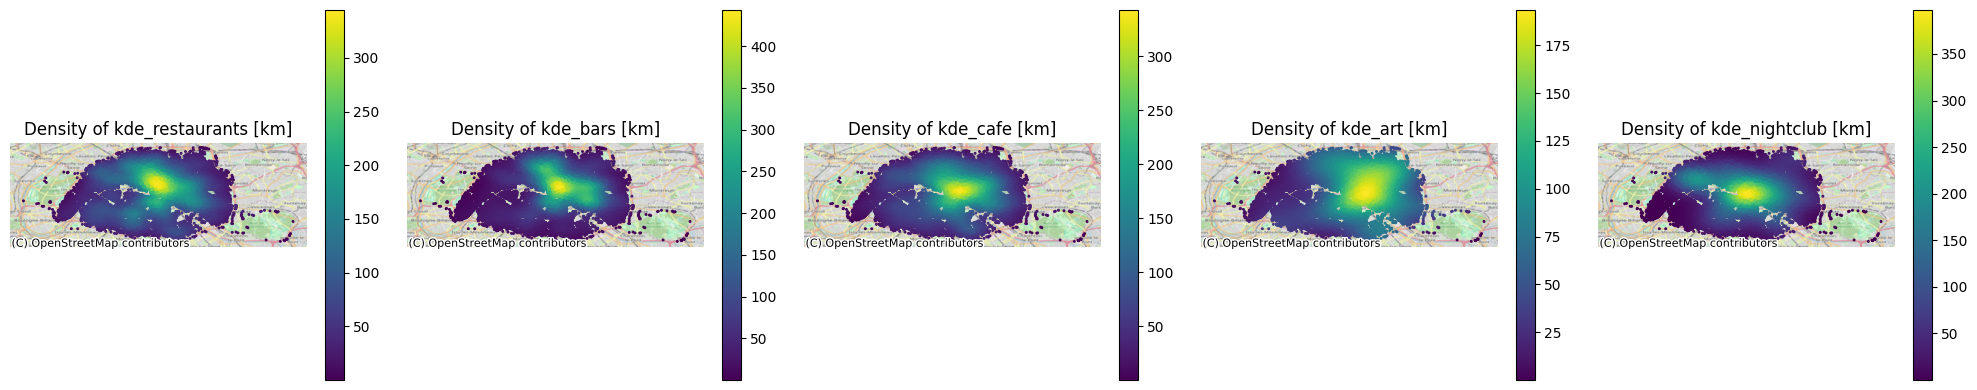

In [215]:
# Define the POIs to plot
kde_columns = ["kde_restaurants", "kde_bars", 
               "kde_cafe", "kde_art", 
               "kde_nightclub"]

num_rows = 1
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4))

# Iterate over each POI column and plot
for i, kde_column in enumerate(kde_columns):
    # Plot the POI locations
    ax = axs[i]
    gdf.plot(ax=ax, column=kde_column, marker=".", s=5, legend=True, cmap='viridis')
    cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)

    # Set title and axis labels
    ax.set_title(f"Density of {kde_column} [km]")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [216]:
# Define the KDE-related feature lists
restaurant_kde = gdf_with_dist_pois + ["kde_restaurants"]
bar_kde = gdf_with_dist_pois + ["kde_bars"]
cafe_kde = gdf_with_dist_pois + ["kde_cafe"]
art_kde = gdf_with_dist_pois + ["kde_art"]
nightclub_kde = gdf_with_dist_pois + ["kde_nightclub"]

# Function to scale the features
def scale_features2(gdf, feature_columns):
    scaler = StandardScaler()
    gdf[feature_columns] = scaler.fit_transform(gdf[feature_columns])
    return gdf

# Scale the features
gdf_scaled = scale_features2(gdf, restaurant_kde)
gdf_scaled = scale_features2(gdf, bar_kde)
gdf_scaled = scale_features2(gdf, cafe_kde)
gdf_scaled = scale_features2(gdf, art_kde)
gdf_scaled = scale_features2(gdf, nightclub_kde)

In [217]:
gdf_with_kde_pois = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count',
            'review_scores_location', 'pt Entire Rental Unit', 'pt Private Room in Rental Unit', 'pt Entire Condo',	'pt Other', 'rt Entire Home/Apt',
            'rt Private Room', 'rt Shared Room', 'rt Hotel Room', 'neighbourhood_Batignolles-Monceau', 'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Montmartre',
            'neighbourhood_Entrepôt', 'neighbourhood_Gobelins', 'neighbourhood_Hôtel-de-Ville', 'neighbourhood_Louvre', 'neighbourhood_Luxembourg',
            'neighbourhood_Ménilmontant', 'neighbourhood_Observatoire', 'neighbourhood_Opéra', 'neighbourhood_Palais-Bourbon', 'neighbourhood_Panthéon',
            'neighbourhood_Passy', 'neighbourhood_Popincourt', 'neighbourhood_Reuilly', 'neighbourhood_Temple', 'neighbourhood_Vaugirard', 'neighbourhood_Élysée', 'dist_to_restaurant', 'dist_to_arts_centre', 'dist_to_cafe', 'dist_to_bar', 'dist_to_nightclub', 'kde_restaurants', 'kde_bars', 'kde_cafe', 'kde_art', 'kde_nightclub']

In [218]:
results4, model4 = perform_cross_validated_regression(gdf, target_var='price', feature_vars=gdf_with_kde_pois)

In [219]:
metrics4 = pd.DataFrame(
    [[results1.rmse.mean, results2.rmse.mean, results3.rmse.mean, results4.rmse.mean],
     [results1.mae.mean, results2.mae.mean, results3.mae.mean, results4.mae.mean],
     [results1.r2_adj.mean, results2.r2_adj.mean, results3.r2_adj.mean, results4.r2_adj.mean]],
    index=["RMSE", "MAE", "R2 Adjusted"],
    columns=["Non Spatial", "With Neighbourhoods", "With Distances to Amenities", "With KDE of Amenities"]
)

In [220]:
metrics4

Non Spatial  With Neighbourhoods  With Distances to Amenities  \
RMSE           73.327495            69.359654                    69.010314   
MAE            53.764690            50.056972                    49.722574   
R2 Adjusted     0.361417             0.427211                     0.432601   

             With KDE of Amenities  
RMSE                     68.651863  
MAE                      49.319188  
R2 Adjusted               0.438117

### Famous location POIs

- Eiffeltower
- Louvre
- Montmarte (Sacre Coeur)
- Notre Dame
- City Center
- Champs-Élysées

In [221]:
# Defining the coordinates of my POIs

pois = {
    'Eiffel Tower': (48.8584, 2.2945),
    'Louvre': (48.8606, 2.3376),
    'Sacre Couer Montmartre': (48.8867, 2.3431),
    'Notre Dame': (48.8530, 2.3499),
    'City Center': (48.85679, 2.35108),  # Coordinates for a central point in Paris
    'Champs-Élysées': (48.8697, 2.3073)
}

In [222]:
def calculate_distance(row, poi_coords):
    listing_coords = (row['latitude'], row['longitude'])
    return geodesic(listing_coords, poi_coords).kilometers

for poi_name, poi_coords in pois.items():
    gdf[poi_name + '_distance'] = gdf.apply(calculate_distance, axis=1, poi_coords=poi_coords)

In [223]:
gdf.head()

id  latitude  longitude  accommodates  bedrooms      beds  price  \
0    3109  48.83191    2.31870     -0.730324 -0.225214 -0.599057  250.0   
1  165409  48.86652    2.36261     -0.730324 -1.399460 -0.599057  140.0   
2    5396  48.85247    2.35835     -0.730324 -1.399460 -0.599057  107.0   
3  166370  48.87623    2.36869      0.527088 -0.225214 -0.599057  200.0   
6    7397  48.85909    2.35315      0.527088  0.949032  0.272395  134.0   

   minimum_nights  number_of_reviews  review_scores_rating  \
0       -0.199759          -0.467332              0.714073   
1       -0.176477           1.001042             -0.088568   
2       -0.223042           5.132642             -0.289229   
3       -0.199759           0.597959             -0.389559   
6       -0.013499           4.484830              0.036844   

   calculated_host_listings_count  review_scores_location  \
0                       -0.284211                0.612159   
1                       -0.284211                0.447932   
2                       -0.270287                0.480777   
3                       -0.284211               -0.537428   
6                       -0.214591                0.382241   

   pt Entire Rental Unit  pt Private Room in Rental Unit  pt Entire Condo  \
0               0.459954                       -0.240538        -0.197979   
1               0.459954                       -0.240538        -0.197979   
2               0.459954                       -0.240538        -0.197979   
3               0.459954                       -0.240538        -0.197979   
6               0.459954                       -0.240538        -0.197979   

   pt Other  rt Entire Home/Apt  rt Private Room  rt Shared Room  \
0 -0.299279            0.343791        -0.317022       -0.070722   
1 -0.299279            0.343791        -0.317022       -0.070722   
2 -0.299279            0.343791        -0.317022       -0.070722   
3 -0.299279            0.343791        -0.317022       -0.070722   
6 -0.299279            0.343791        -0.317022       -0.070722   

   rt Hotel Room                  geometry  neighbourhood_Batignolles-Monceau  \
0      -0.097401  POINT (2.31870 48.83191)                          -0.259255   
1      -0.097401  POINT (2.36261 48.86652)                          -0.259255   
2      -0.097401  POINT (2.35835 48.85247)                          -0.259255   
3      -0.097401  POINT (2.36869 48.87623)                          -0.259255   
6      -0.097401  POINT (2.35315 48.85909)                          -0.259255   

   neighbourhood_Bourse  neighbourhood_Buttes-Chaumont  \
0             -0.208162                      -0.239949   
1             -0.208162                      -0.239949   
2             -0.208162                      -0.239949   
3             -0.208162                      -0.239949   
6             -0.208162                      -0.239949   

   neighbourhood_Buttes-Montmartre  neighbourhood_Entrepôt  \
0                        -0.348732               -0.279172   
1                        -0.348732               -0.279172   
2                        -0.348732               -0.279172   
3                        -0.348732                3.582023   
6                        -0.348732               -0.279172   

   neighbourhood_Gobelins  neighbourhood_Hôtel-de-Ville  neighbourhood_Louvre  \
0               -0.181915                     -0.194578             -0.160824   
1               -0.181915                     -0.194578             -0.160824   
2               -0.181915                      5.139333             -0.160824   
3               -0.181915                     -0.194578             -0.160824   
6               -0.181915                      5.139333             -0.160824   

   neighbourhood_Luxembourg  neighbourhood_Ménilmontant  \
0                 -0.173442                   -0.234903   
1                 -0.173442                   -0.234903   
2                 -0.173442                   -0.234903   
3           

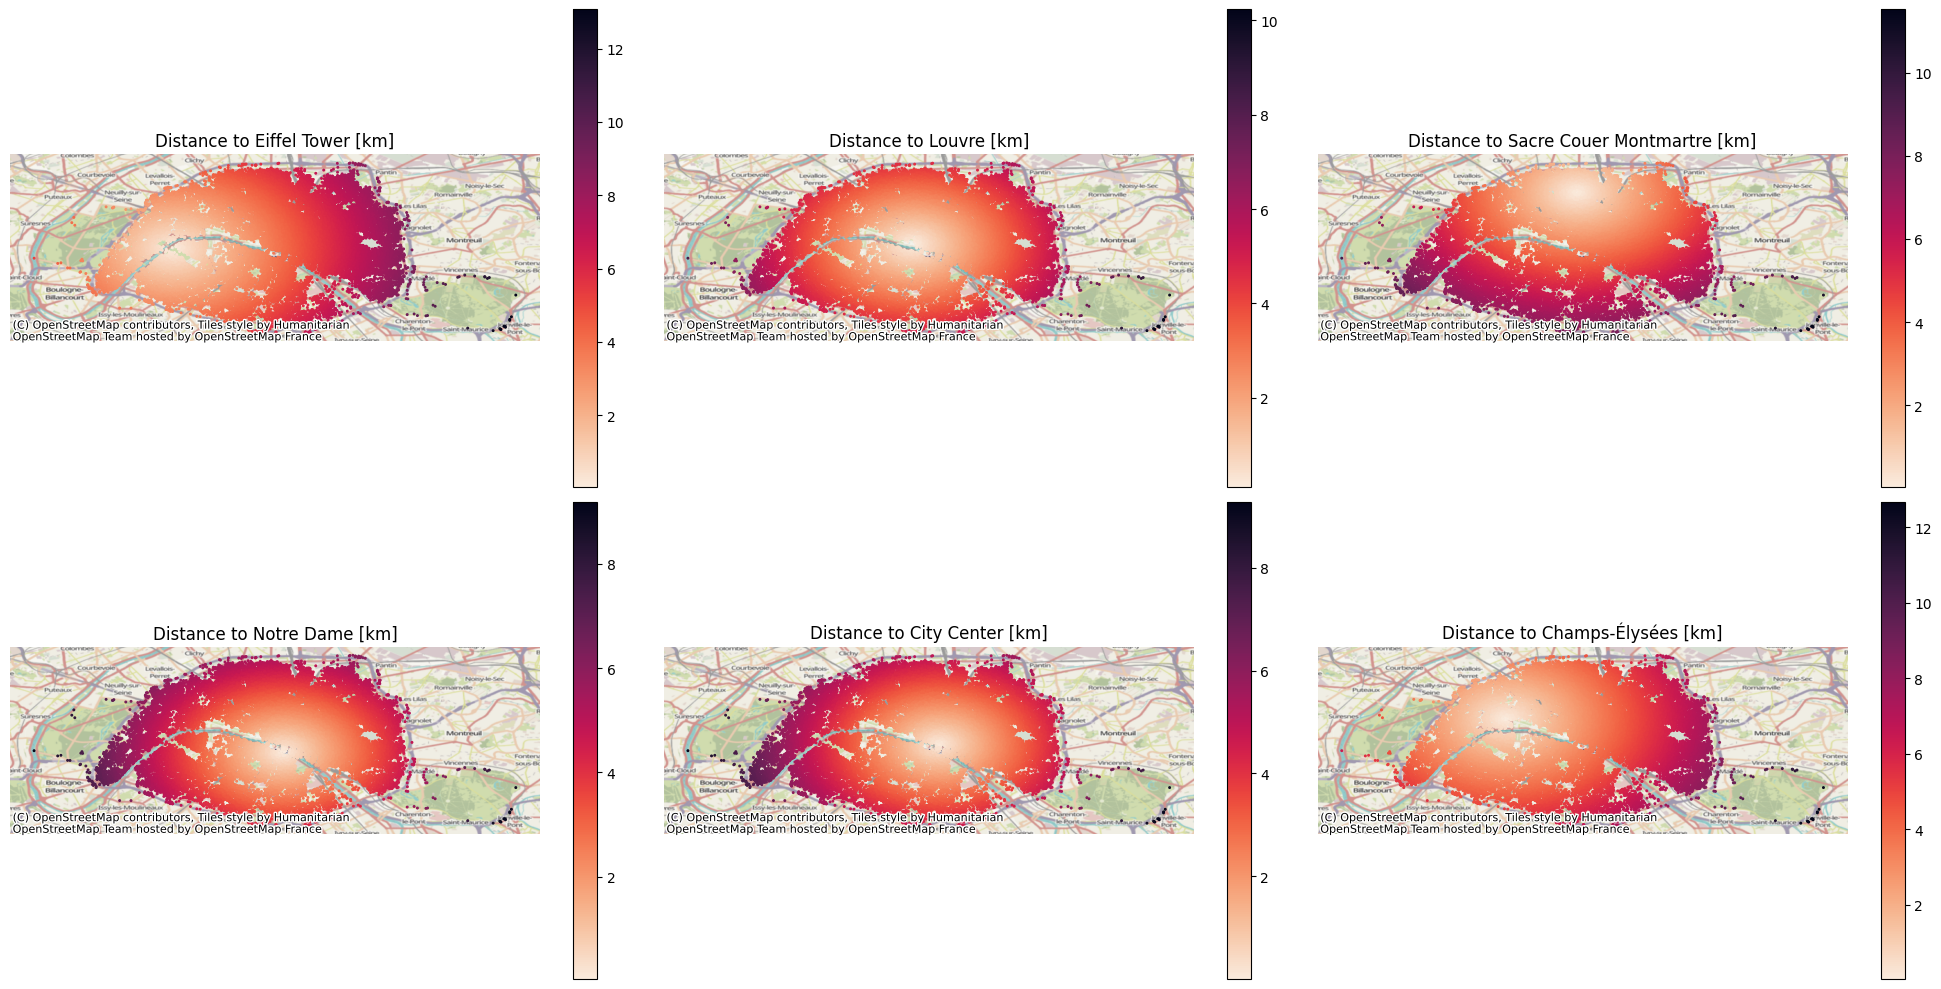

In [224]:
# Define the POIs to plot
poi_columns = ["Eiffel Tower_distance", "Louvre_distance", 
               "Sacre Couer Montmartre_distance", "Notre Dame_distance", 
               "City Center_distance", "Champs-Élysées_distance"]

num_rows = 2
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Iterate over each POI column and plot
for i, poi_column in enumerate(poi_columns):
    # Determine row and column index for the current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    # Plot the POI locations
    ax = axs[row_idx, col_idx]
    gdf.plot(ax=ax, column=poi_column, marker=".", s=5, legend=True, cmap="rocket_r")
    cx.add_basemap(ax, crs=gdf.crs)

    # Set title and axis labels
    title = poi_column.replace('_', ' ').replace(' distance', '')
    ax.set_title(f"Distance to {title} [km]")
    ax.set_axis_off()

plt.tight_layout()
plt.show()


In [225]:
# Function to scale the features
def scale_features3(gdf, feature_columns):
    scaler = StandardScaler()
    gdf[feature_columns] = scaler.fit_transform(gdf[feature_columns])
    return gdf

# Define the distances as lists of column names
eiffeltower = ["Eiffel Tower_distance"]
louvre = ["Louvre_distance"]
sacrecoeur = ["Sacre Couer Montmartre_distance"]
notredame = ["Notre Dame_distance"]
citycenter = ["City Center_distance"]
champselysees = ["Champs-Élysées_distance"]

# Scale each set of features in gdf
gdf_scaled_eiffeltower = scale_features3(gdf.copy(), eiffeltower)
gdf_scaled_louvre = scale_features3(gdf.copy(), louvre)
gdf_scaled_sacrecoeur = scale_features3(gdf.copy(), sacrecoeur)
gdf_scaled_notredame = scale_features3(gdf.copy(), notredame)
gdf_scaled_citycenter = scale_features3(gdf.copy(), citycenter)
gdf_scaled_champselysees = scale_features3(gdf.copy(), champselysees)


In [226]:
gdf_with_pois = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count',
            'review_scores_location', 'pt Entire Rental Unit', 'pt Private Room in Rental Unit', 'pt Entire Condo', 'pt Other',	'rt Entire Home/Apt',
            'rt Private Room', 'rt Shared Room', 'rt Hotel Room', 'neighbourhood_Batignolles-Monceau', 'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Montmartre',
            'neighbourhood_Entrepôt', 'neighbourhood_Gobelins', 'neighbourhood_Hôtel-de-Ville', 'neighbourhood_Louvre', 'neighbourhood_Luxembourg',
            'neighbourhood_Ménilmontant', 'neighbourhood_Observatoire', 'neighbourhood_Opéra', 'neighbourhood_Palais-Bourbon', 'neighbourhood_Panthéon',
            'neighbourhood_Passy', 'neighbourhood_Popincourt', 'neighbourhood_Reuilly', 'neighbourhood_Temple', 'neighbourhood_Vaugirard', 'neighbourhood_Élysée', 'dist_to_restaurant', 'dist_to_arts_centre', 'dist_to_cafe', 'dist_to_bar', 'dist_to_nightclub', 'kde_restaurants', 'kde_bars', 'kde_cafe', 'kde_art', 'kde_nightclub', 'Eiffel Tower_distance', 'Louvre_distance', 'Sacre Couer Montmartre_distance', 'Notre Dame_distance', 'City Center_distance', 'Champs-Élysées_distance']


results5, model5 = perform_cross_validated_regression(gdf, target_var='price', feature_vars=gdf_with_pois)

In [227]:
metrics5 = pd.DataFrame(
    [[results1.rmse.mean, results2.rmse.mean, results3.rmse.mean, results4.rmse.mean, results5.rmse.mean],
     [results1.mae.mean, results2.mae.mean, results3.mae.mean, results4.mae.mean, results5.mae.mean],
     [results1.r2_adj.mean, results2.r2_adj.mean, results3.r2_adj.mean, results4.r2_adj.mean, results5.r2_adj.mean]],
    index=["RMSE", "MAE", "R2 Adjusted"],
    columns=["Non Spatial", "With Neighbourhoods", "With Distances to Amenities", "With KDE of Amenities", "With Distances to POIs"]
)

In [228]:
metrics5

Non Spatial  With Neighbourhoods  With Distances to Amenities  \
RMSE           73.327495            69.359654                    69.010314   
MAE            53.764690            50.056972                    49.722574   
R2 Adjusted     0.361417             0.427211                     0.432601   

             With KDE of Amenities  With Distances to POIs  
RMSE                     68.651863               68.257111  
MAE                      49.319188               49.001751  
R2 Adjusted               0.438117                0.444140

### Adding Spatially Lagged Features

In [229]:
def calculate_spatial_lag(gdf, weights, variable):
    """Calculate the spatial lag of a given variable."""
    lagged_values = weights.sparse.dot(gdf[variable].values)

    scaler = StandardScaler()
    lagged_values_standardized = scaler.fit_transform(lagged_values.reshape(-1, 1))

    return lagged_values_standardized.flatten()

def perform_cross_validated_regression_slx(gdf, target_var, exog_vars, n_splits=5):
    # Define namedtuples for storing the metrics
    Metrics = namedtuple('Metrics', ['mean', 'std_dev'])
    AllMetrics = namedtuple('AllMetrics', ['rmse', 'mae', 'r2_adjusted'])
    
    # Split the data into features and target variable
    X = gdf[exog_vars]
    y = gdf[target_var]
    
    # Create a spatial weights matrix based on the geometry column
    weights = Queen.from_dataframe(gdf)
    
    # Calculate spatially lagged values for selected exogenous variables
    for feature in exog_vars:
        if feature in ['number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count',
                       'review_scores_location', 'pt Entire Rental Unit', 'pt Private Room in Rental Unit',
                       'pt Entire Condo', 'pt Other', 'rt Entire Home/Apt', 'rt Private Room',
                       'rt Shared Room', 'rt Hotel Room']:
            gdf[f'spatial_lag_{feature}'] = calculate_spatial_lag(gdf, weights, feature)
    
    # Add spatially lagged features to the feature set
    spatial_lag_features = [f'spatial_lag_{feature}' for feature in exog_vars if feature in ['number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count',
                                                                                            'review_scores_location', 'pt Entire Rental Unit', 'pt Private Room in Rental Unit',
                                                                                            'pt Entire Condo', 'pt Other', 'rt Entire Home/Apt', 'rt Private Room',
                                                                                            'rt Shared Room', 'rt Hotel Room']]
    all_feature_vars = exog_vars + spatial_lag_features
    
    # Initialize the KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initialize lists to store the metrics for each fold
    rmse_list = []
    mae_list = []
    r2adjusted_list = []

    for train_index, val_index in kf.split(gdf):
        X_train, X_val = gdf.iloc[train_index][all_feature_vars], gdf.iloc[val_index][all_feature_vars]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Fit the OLS model on the training data
        model = sm.OLS(endog=y_train, exog=sm.add_constant(X_train))
        results = model.fit()
        
        # Predict on the validation data
        X_val_const = sm.add_constant(X_val)
        predicted_val = results.predict(X_val_const)
        
        # Calculate the metrics on the validation data
        rmse = np.sqrt(mean_squared_error(y_val, predicted_val))
        mae = mean_absolute_error(y_val, predicted_val)
        r2 = r2_score(y_val, predicted_val)
        
        # Calculate adjusted R-squared 
        n = X_val.shape[0]  # Number of observations in validation set
        p = X_val.shape[1]  # Number of predictors in the model
        r_squared_adj = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
        
        # Append the metrics to the lists
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2adjusted_list.append(r_squared_adj)
    
    # Calculate the mean and standard deviation of the metrics
    rmse_metrics = Metrics(mean=np.mean(rmse_list), std_dev=np.std(rmse_list))
    mae_metrics = Metrics(mean=np.mean(mae_list), std_dev=np.std(mae_list))
    r2adjusted_metrics = Metrics(mean=np.mean(r2adjusted_list), std_dev=np.std(r2adjusted_list))
    
    # Store all metrics in a namedtuple
    all_metrics = AllMetrics(
        rmse=rmse_metrics,
        mae=mae_metrics,
        r2_adjusted=r2adjusted_metrics
    )
    
    return all_metrics, results

In [230]:
results_slx, model_slx = perform_cross_validated_regression_slx(gdf, target_var='price', exog_vars=gdf_with_pois)

/var/folders/ld/dtk9yjf946lgsbhl38x8n4f80000gp/T/ipykernel_2365/3867691247.py:20: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = Queen.from_dataframe(gdf)


In [231]:
gdf.head()

id  latitude  longitude  accommodates  bedrooms      beds  price  \
0    3109  48.83191    2.31870     -0.730324 -0.225214 -0.599057  250.0   
1  165409  48.86652    2.36261     -0.730324 -1.399460 -0.599057  140.0   
2    5396  48.85247    2.35835     -0.730324 -1.399460 -0.599057  107.0   
3  166370  48.87623    2.36869      0.527088 -0.225214 -0.599057  200.0   
6    7397  48.85909    2.35315      0.527088  0.949032  0.272395  134.0   

   minimum_nights  number_of_reviews  review_scores_rating  \
0       -0.199759          -0.467332              0.714073   
1       -0.176477           1.001042             -0.088568   
2       -0.223042           5.132642             -0.289229   
3       -0.199759           0.597959             -0.389559   
6       -0.013499           4.484830              0.036844   

   calculated_host_listings_count  review_scores_location  \
0                       -0.284211                0.612159   
1                       -0.284211                0.447932   
2                       -0.270287                0.480777   
3                       -0.284211               -0.537428   
6                       -0.214591                0.382241   

   pt Entire Rental Unit  pt Private Room in Rental Unit  pt Entire Condo  \
0               0.459954                       -0.240538        -0.197979   
1               0.459954                       -0.240538        -0.197979   
2               0.459954                       -0.240538        -0.197979   
3               0.459954                       -0.240538        -0.197979   
6               0.459954                       -0.240538        -0.197979   

   pt Other  rt Entire Home/Apt  rt Private Room  rt Shared Room  \
0 -0.299279            0.343791        -0.317022       -0.070722   
1 -0.299279            0.343791        -0.317022       -0.070722   
2 -0.299279            0.343791        -0.317022       -0.070722   
3 -0.299279            0.343791        -0.317022       -0.070722   
6 -0.299279            0.343791        -0.317022       -0.070722   

   rt Hotel Room                  geometry  neighbourhood_Batignolles-Monceau  \
0      -0.097401  POINT (2.31870 48.83191)                          -0.259255   
1      -0.097401  POINT (2.36261 48.86652)                          -0.259255   
2      -0.097401  POINT (2.35835 48.85247)                          -0.259255   
3      -0.097401  POINT (2.36869 48.87623)                          -0.259255   
6      -0.097401  POINT (2.35315 48.85909)                          -0.259255   

   neighbourhood_Bourse  neighbourhood_Buttes-Chaumont  \
0             -0.208162                      -0.239949   
1             -0.208162                      -0.239949   
2             -0.208162                      -0.239949   
3             -0.208162                      -0.239949   
6             -0.208162                      -0.239949   

   neighbourhood_Buttes-Montmartre  neighbourhood_Entrepôt  \
0                        -0.348732               -0.279172   
1                        -0.348732               -0.279172   
2                        -0.348732               -0.279172   
3                        -0.348732                3.582023   
6                        -0.348732               -0.279172   

   neighbourhood_Gobelins  neighbourhood_Hôtel-de-Ville  neighbourhood_Louvre  \
0               -0.181915                     -0.194578             -0.160824   
1               -0.181915                     -0.194578             -0.160824   
2               -0.181915                      5.139333             -0.160824   
3               -0.181915                     -0.194578             -0.160824   
6               -0.181915                      5.139333             -0.160824   

   neighbourhood_Luxembourg  neighbourhood_Ménilmontant  \
0                 -0.173442                   -0.234903   
1                 -0.173442                   -0.234903   
2                 -0.173442                   -0.234903   
3           

In [232]:
final = pd.DataFrame(
    [[results1.rmse.mean, results2.rmse.mean, results3.rmse.mean, results4.rmse.mean, results5.rmse.mean, results_slx.rmse.mean],
     [results1.mae.mean, results2.mae.mean, results3.mae.mean, results4.mae.mean, results5.mae.mean, results_slx.mae.mean],
     [results1.r2_adj.mean, results2.r2_adj.mean, results3.r2_adj.mean, results4.r2_adj.mean, results5.r2_adj.mean, results_slx.r2_adjusted.mean]],
    index=["RMSE", "MAE", "R2 Adjusted"],
    columns=["Non Spatial", "With Neighbourhoods", "With Distances to Amenities", "With KDE of Amenities", "With Distances to POIs", "With SLX for some x-variables"]
)

In [233]:
final

Non Spatial  With Neighbourhoods  With Distances to Amenities  \
RMSE           73.327495            69.359654                    69.010314   
MAE            53.764690            50.056972                    49.722574   
R2 Adjusted     0.361417             0.427211                     0.432601   

             With KDE of Amenities  With Distances to POIs  \
RMSE                     68.651863               68.257111   
MAE                      49.319188               49.001751   
R2 Adjusted               0.438117                0.444140   

             With SLX for some x-variables  
RMSE                             68.166957  
MAE                              48.875561  
R2 Adjusted                       0.444754

In [234]:
# Function to truncate numbers to 4 decimal places
def truncate_to_4_decimals(num):
    return f"{num:.4f}"

In [235]:
# Truncate the values to 4 decimal places
final = final.applymap(lambda x: truncate_to_4_decimals(x))

In [236]:
final

Non Spatial With Neighbourhoods With Distances to Amenities  \
RMSE            73.3275             69.3597                     69.0103   
MAE             53.7647             50.0570                     49.7226   
R2 Adjusted      0.3614              0.4272                      0.4326   

            With KDE of Amenities With Distances to POIs  \
RMSE                      68.6519                68.2571   
MAE                       49.3192                49.0018   
R2 Adjusted                0.4381                 0.4441   

            With SLX for some x-variables  
RMSE                              68.1670  
MAE                               48.8756  
R2 Adjusted                        0.4448

### Importance of each Feature

In [237]:
feature_importances = model_slx.params

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

pd.Series(feature_importances).sort_values(ascending=False)

const                                         254.603752
City Center_distance                           49.637220
accommodates                                   35.492795
bedrooms                                       21.564237
kde_nightclub                                  18.875131
kde_cafe                                       11.821066
review_scores_rating                           11.784998
Louvre_distance                                10.804441
rt Hotel Room                                   6.971295
Champs-Élysées_distance                         6.244527
pt Other                                        5.591253
neighbourhood_Temple                            4.338793
neighbourhood_Popincourt                        3.670578
neighbourhood_Entrepôt                          3.499609
neighbourhood_Buttes-Chaumont                   3.333518
neighbourhood_Hôtel-de-Ville                    3.003977
spatial_lag_review_scores_location              2.817502
neighbourhood_Ménilmontant     